Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github

# CoronaVirus Prediction

### Number of Day to Predict 42

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=42
num_BackTrack_Days=4

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=24 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=443 => 15/04/2021
#
drop_n_dataset_days=447
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
250                                           NaN                    Togo   
251                                           NaN                   Tonga   
252                                           NaN     Trinidad and Tobago   
253                                           NaN                 Tunisia   
254                                           NaN                  Turkey   
255                                           NaN           United States   
256                                           NaN                  Uganda   
257                                           NaN                 Ukraine   
258                                           NaN    United Arab Emirates   
259                                      Anguilla          United Kingdom   
260                                       Bermuda          United Kingdom   
261                        British Virgin Islands          United Kingdom   
262                                Cayman Islands          United Kingdom   
263                               Channel Islands          United Kingdom   
264                   Falkland Islands (Malvinas)          United Kingdom   
265                                     Gibraltar          United Kingdom   
266                                   Isle of Man          United Kingdom   
267                                    Montserrat          United Kingdom   
268  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
269                      Turks and Caicos Islands          United Kingdom   
270                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
256                                           NaN                    Togo   
257                                           NaN                   Tonga   
258                                           NaN     Trinidad and Tobago   
259                                           NaN                 Tunisia   
260                                           NaN                  Turkey   
261                                           NaN           United States   
262                                           NaN                  Uganda   
263                                           NaN                 Ukraine   
264                                           NaN    United Arab Emirates   
265                                      Anguilla          United Kingdom   
266                                       Bermuda          United Kingdom   
267                        British Virgin Islands          United Kingdom   
268                                Cayman Islands          United Kingdom   
269                               Channel Islands          United Kingdom   
270                   Falkland Islands (Malvinas)          United Kingdom   
271                                     Gibraltar          United Kingdom   
272                                   Isle of Man          United Kingdom   
273                                    Montserrat          United Kingdom   
274  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
275                      Turks and Caicos Islands          United Kingdom   
276                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/26/21  12/27/21  12/28/21  \
185        0        0        0        0  ...       475       476       476   
186        0        0        0        0  ...         0         0         0   
187        0        0        0        0  ...       862       862       862   
188        0        0        0        0  ...       240       240       240   
189        0        0        0        0  ...    298759    298777    298819   
190        0        0        0        0  ...         0         0         0   
191        0        0        0        0  ...      9613      9625      9645   
192        0        0        0        0  ...        38        38        38   
193        0        0        0        0  ...      2055      2056      2056   
194        0        0        0        0  ...      2394      2395      2402   

     12/29/21  12/30/21  12/31/21  1/1/22  1/2/22   Population   \
185       476       476       476     477     479       441,543   
186         0         0         0       0       0           NaN   
187       862       863       866     870     872     4,649,658   
188       240       240       240     240     240     1,273,985   
189    298944    299132    299428  299428  299525   128,640,794   
190         0         0         0       0       0           NaN   
191      9667      9690     10275   10284   10290     4,035,942   
192        38        38        38      39      39        39,183   
193      2058      2059      2059    2060    2060     3,278,290   
194      2401      2407      2411    2414    2416       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 718 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN         Monaco  43.733300    7.41670   
176                               NaN       Mongolia  46.862500  103.84670   
177                               NaN     Montenegro  42.708678   19.37439   
178                               NaN        Morocco  31.791700   -7.09260   
179                               NaN     Mozambique -18.665700   35.52960   
180                               NaN        Namibia -22.957600   18.49040   
181                               NaN          Nepal  28.166700   84.25000   
182                             Aruba    Netherlands  12.521100  -69.96830   
183  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   
184                           Curacao    Netherlands  12.169600  -68.99000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/26/21  \
175        0        0        0        0        0        0  ...         0   
176        0        0        0        0        0        0  ...         0   
177        0        0        0        0        0        0  ...         0   
178        0        0        0        0        0        0  ...         0   
179        0        0        0        0        0        0  ...         0   
180        0        0        0        0        0        0  ...         0   
181        0        0        0        0        0        0  ...         0   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...         0   
184        0        0        0        0        0        0  ...         0   

     12/27/21  12/28/21  12/29/21  12/30/21  12/31/21  1/1/22  1/2/22  \
175         0         0         0         0         0       0       0   
176         0         0         0         0         0       0       0   
177         0         0         0         0         0       0       0   
178         0         0         0         0         0       0       0   
179         0         0         0         0         0       0       0   
180         0         0         0         0         0       0       0   
181         0         0         0         0         0       0       0   
182         0         0         0         0         0       0       0   
183         0         0         0         0         0       0       0   
184         0         0         0         0         0       0       0   

      Population                                         region  
175        39,183                                    Monaco_nan  
176     3,278,290                                  Mongolia_nan  
177       622 500                                Montenegro_nan  
178    36,817,128                                   Morocco_nan  
179    31,542,919                                Mozambique_nan  
180     2,540,905                                   Namibia_nan  
181    29,300,000                                     Nepal_nan  
182       116,600                             Netherlands_Aruba  
183        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  
184       158,665                           Netherlands_Curacao  

[10 rows x 718 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/26/21  12/27/21  12/28/21  \
185        0        0        0        0  ...     46250     47082     48380   
186        0        0        0        0  ...         4         4         4   
187        0        0        0        0  ...     40504     40614     40737   
188        0        0        0        0  ...     23170     23208     23208   
189        0        0        0        0  ...   3950200   3951003   3951946   
190        0        0        0        0  ...         1         1         1   
191        0        0        0        0  ...    374526    374763    375065   
192        0        0        0        0  ...      4766      4809      4889   
193        0        0        0        0  ...    388598    388755    388755   
194        0        0        0        0  ...    163373    163954    165074   

     12/29/21  12/30/21  12/31/21   1/1/22   1/2/22   Population   \
185     49717     51070     52473    53503    54250       441,543   
186         4         4         4        4        4           NaN   
187     40906     41154     41473    41867    42182     4,649,658   
188     23293     23372     23493    23493    23602     1,273,985   
189   3956372   3961662   3979723  3979723  3988916   128,640,794   
190         1         1         1        1        1           NaN   
191    375358    375780    376155   376434   376602     4,035,942   
192      4985      4985      4985     4985     4985        39,183   
193    389089    389361    389361   389876   389876     3,278,290   
194    166581    168328    170034   171873   173161       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 718 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                          Portugal  39.399900   -8.224500   
221            NaN                             Qatar  25.354800   51.183900   
222            NaN                           Romania  45.943200   24.966800   
223            NaN                            Russia  61.524010  105.318756   
224            NaN                            Rwanda  -1.940300   29.873900   
225            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
226            NaN                       Saint Lucia  13.909400  -60.978900   
227            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
228            NaN                             Samoa -13.759000 -172.104600   
229            NaN                        San Marino  43.942400   12.457800   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/26/21  \
220        0        0        0        0        0        0  ...   1279785   
221        0        0        0        0        0        0  ...    248092   
222        0        0        0        0        0        0  ...   1802745   
223        0        0        0        0        0        0  ...  10213265   
224        0        0        0        0        0        0  ...    105027   
225        0        0        0        0        0        0  ...      2843   
226        0        0        0        0        0        0  ...     13302   
227        0        0        0        0        0        0  ...      5828   
228        0        0        0        0        0        0  ...         3   
229        0        0        0        0        0        0  ...      7526   

     12/27/21  12/28/21  12/29/21  12/30/21  12/31/21    1/1/22    1/2/22  \
220   1286119   1303291   1330158   1358817   1389646   1412936   1424016   
221    248435    248802    249245    249787    250528    251361    252359   
222   1803311   1804455   1805726   1807223   1808891   1810342   1811300   
223  10236301  10258052  10279009  10299923  10320405  10340011  10358099   
224    105989    106987    109070    110558    111786    112654    113582   
225      2848      2877      2918      2918      2999      3043      3193   
226     13319     13357     13410     13473     13570     13640     13732   
227      5828      5843      5850      5850      5850      5850      5952   
228         3         3         3         3         3         3         3   
229      7656      7657      7808      7808      8202      8202      8202   

      Population                                 region  
220    10,290,000                          Portugal_nan  
221     2,870,256                             Qatar_nan  
222    19,530,000                           Romania_nan  
223   144,500,000                            Russia_nan  
224    12,952,218                            Rwanda_nan  
225        53,673             Saint Kitts and Nevis_nan  
226       184,106                       Saint Lucia_nan  
227       110,940  Saint Vincent and the Grenadines_nan  
228           NaN                             Samoa_nan  
229        33,916                        San Marino_nan  

[10 rows x 718 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

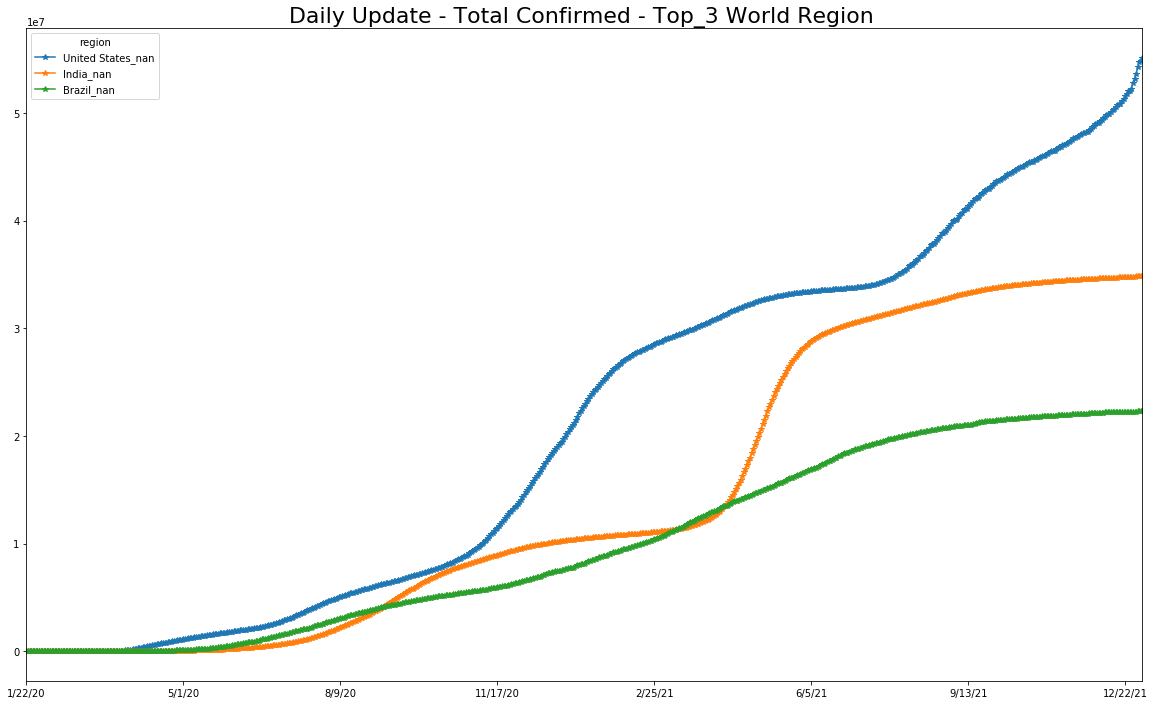

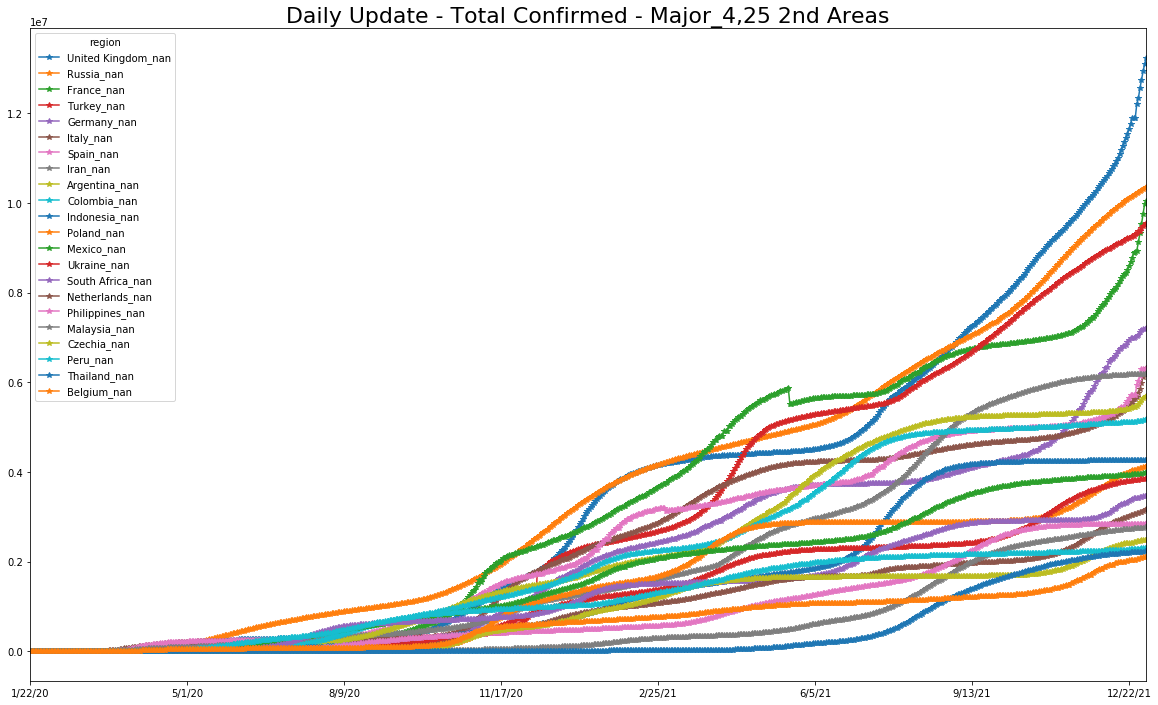

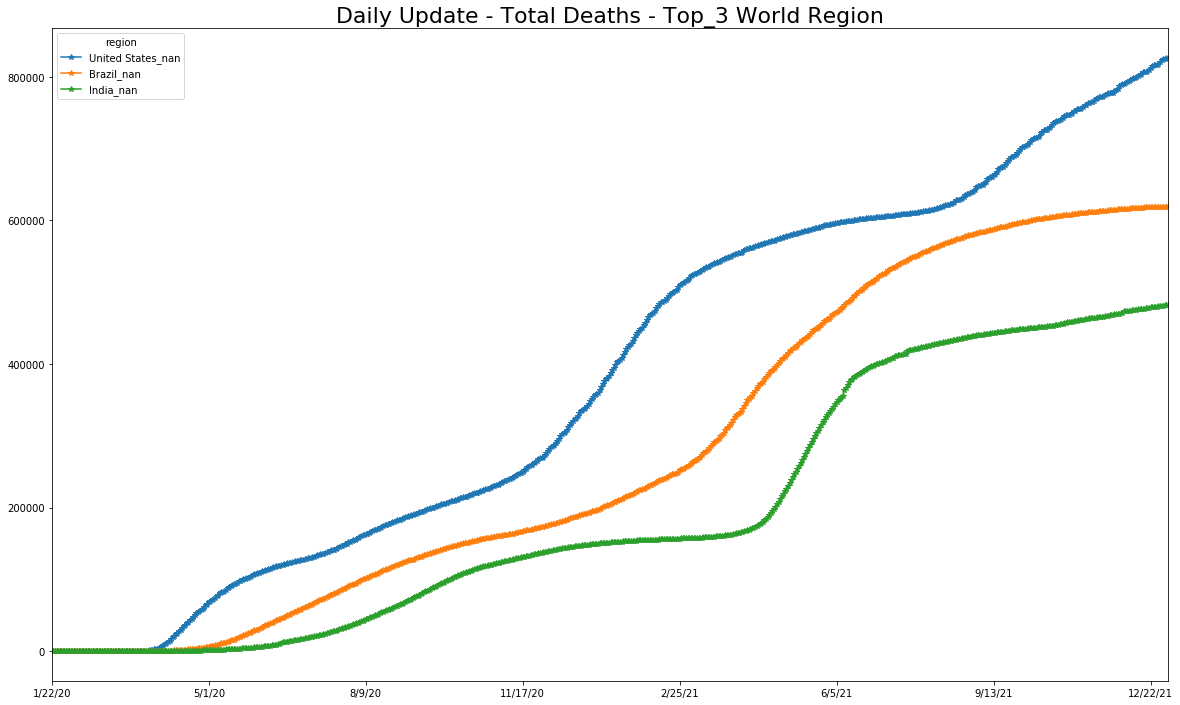

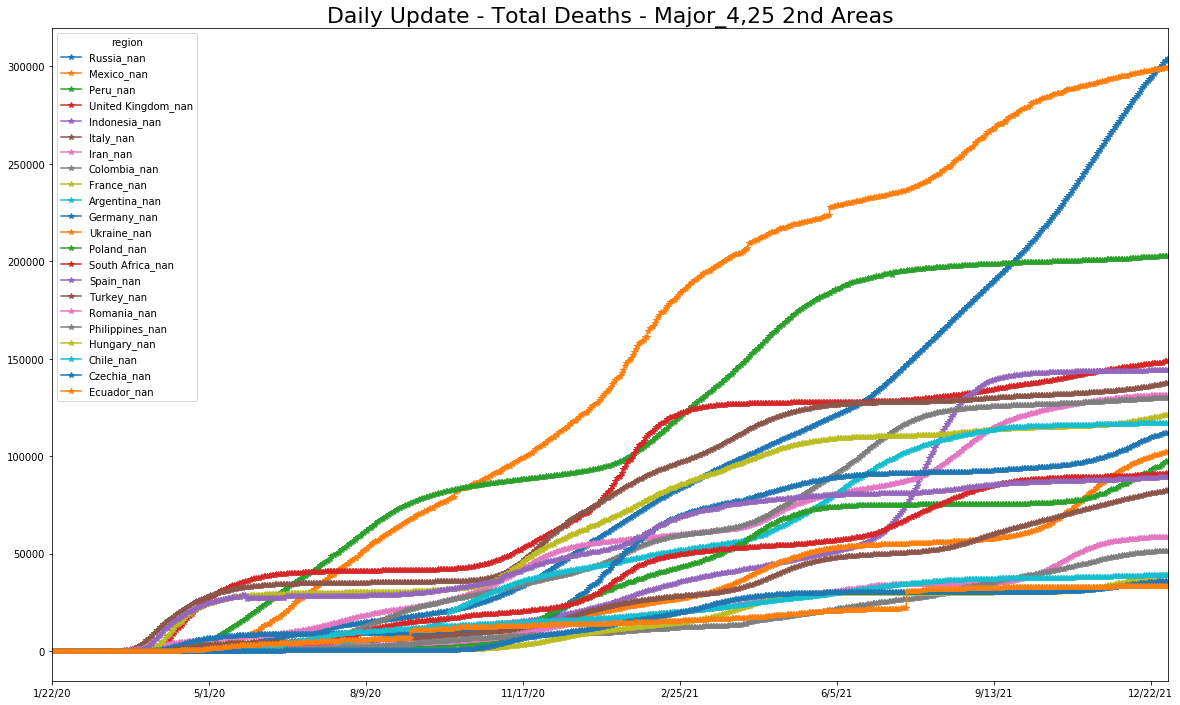

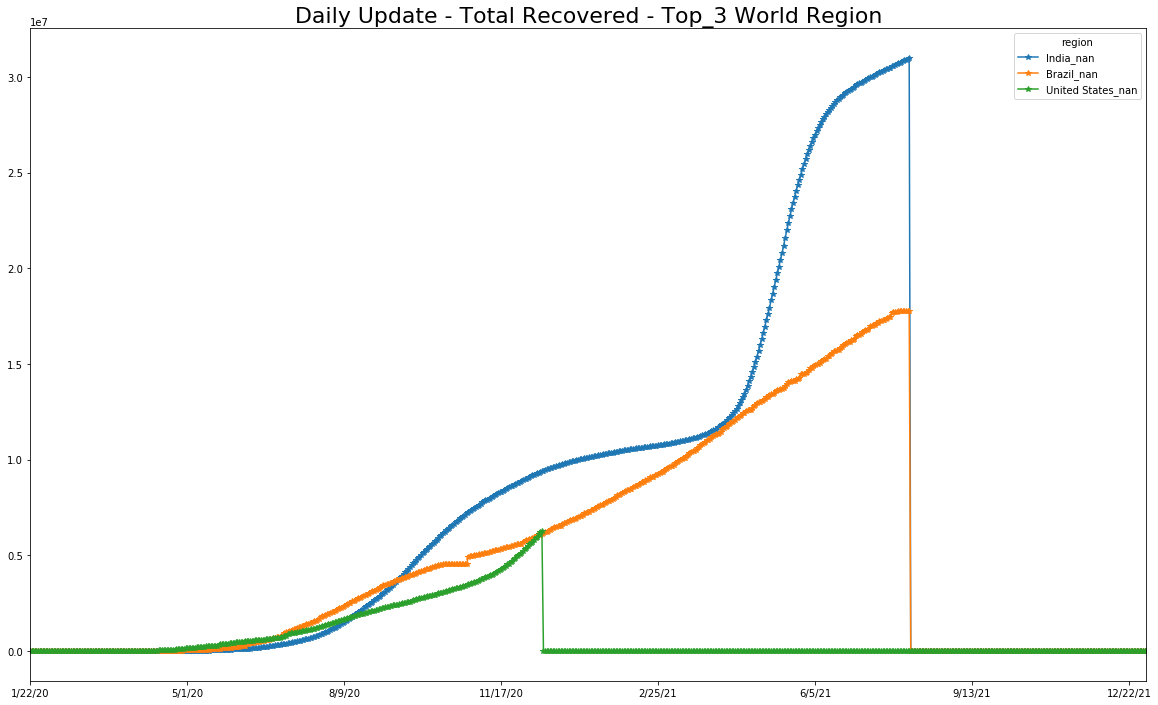

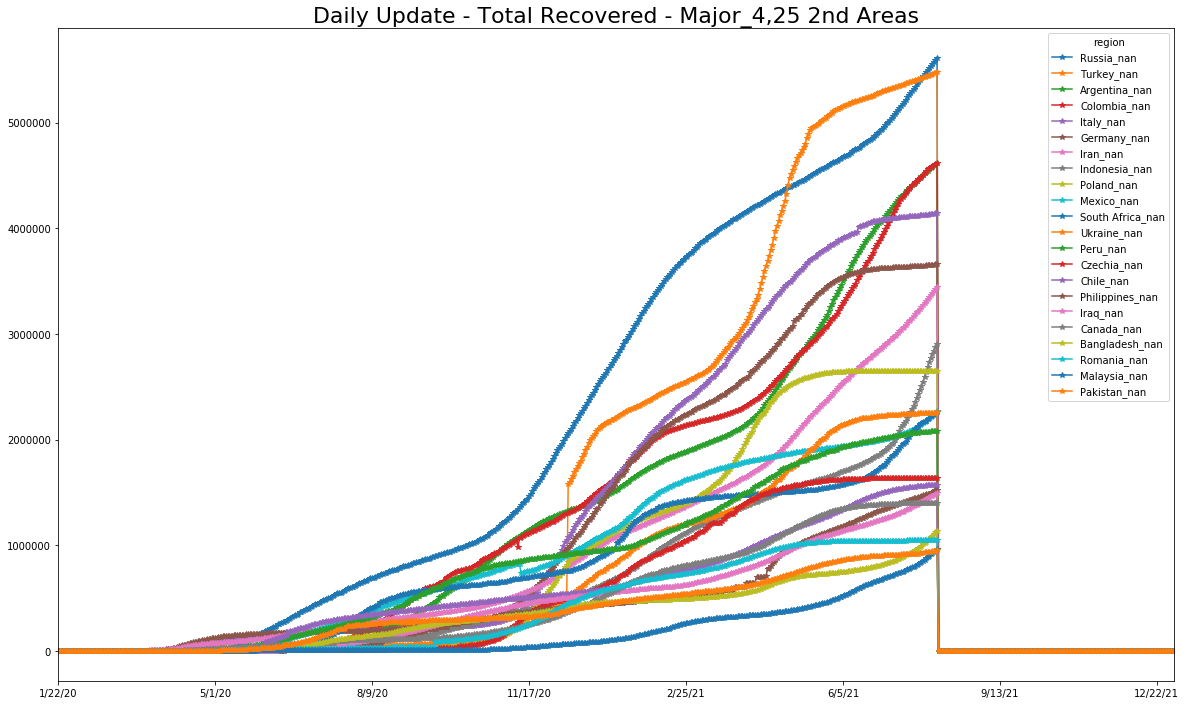

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/01/03


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
4/13/21            57364       128752       118799        12614       23697   
4/14/21            57492       128959       118975        12641       23841   
4/15/21            57534       129128       119142        12641       23951   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
4/13/21                     1201        2579000       204053   
4/14/21                     1201        2604157       205128   
4/15/21                     1209        2629156       206142   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
4/13/21                                     123                       5347   
4/14/21                                     123                       5356   
4/15/21                                     123                       5363   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
4/13/21  ...           31420459       149430           85291            3   
4/14/21  ...           31495775       152089           85503            3   
4/15/21  ...           31569685       156499           85730            3   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
4/13/21         176972         2714                  272767       5507   
4/14/21         178094         2733                  274690       5582   
4/15/21         179365         2758                  276407       5657   

region   Zambia_nan  Zimbabwe_nan  
4/13/21       90218         37330  
4/14/21       90389         37369  
4/15/21       90532         37422  

[3 rows x 280 columns]

In [25]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
12/30/21           158056       208899       218037        23122       79871   
12/31/21           158084       210224       218432        23740       81593   
1/1/22             158107       210224       218818        23740       82398   
1/2/22             158189       210885       219159        23740       82920   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
12/30/21                     4283        5606745       344826   
12/31/21                     4283        5654408       344930   
1/1/22                       4283        5674428       344980   
1/2/22                       4283        5694930       345007   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
12/30/21                                    3564                     166373   
12/31/21                                    4010                     187504   
1/1/22                                      4919                     228307   
1/2/22                                      5323                     249064   

region    ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
12/30/21  ...           54246831       411658          198769            7   
12/31/21  ...           54743982       413383          198903            7   
1/1/22    ...           54859966       414294          199030            7   
1/2/22    ...           55114057       415249          199118            7   

region    Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
12/30/21         444411      1714742                  469748      10126   
12/31/21         444635      1731257                  469748      10126   
1/1/22           444828      1746092                  469748      10127   
1/2/22           444972      1763040                  469748      10130   

region    Zambia_nan  Zimbabwe_nan  
12/30/21      249193        211728  
12/31/21      254274        213258  
1/1/22        257948        214214  
1/2/22        259677        214214  

[4 rows x 280 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-04-14  Afghanistan_nan      57492             0             0   
2     2021-04-15  Afghanistan_nan      57534           128             0   
3     2021-04-16  Afghanistan_nan      57612            42             0   
4     2021-04-17  Afghanistan_nan      57721            78           248   
5     2021-04-18  Afghanistan_nan      57793           109           229   
6     2021-04-19  Afghanistan_nan      57898            72           259   
7     2021-04-20  Afghanistan_nan      58037           105           286   
8     2021-04-21  Afghanistan_nan      58214           139           316   
9     2021-04-22  Afghanistan_nan      58312           177           421   
10    2021-04-23  Afghanistan_nan      58542            98           414   
11    2021-04-24  Afghanistan_nan      58730           230           505   
12    2021-04-25  Afghanistan_nan      58843           188           516   
13    2021-04-26  Afghanistan_nan      59015           113           531   
14    2021-04-27  Afghanistan_nan      59225           172           473   
15    2021-04-28  Afghanistan_nan      59370           210           495   
16    2021-04-29  Afghanistan_nan      59576           145           527   
17    2021-04-30  Afghanistan_nan      59745           206           561   
18    2021-05-01  Afghanistan_nan      59939           169           520   
19    2021-05-02  Afghanistan_nan      60122           194           569   
20    2021-05-03  Afghanistan_nan      60300           183           546   
21    2021-05-04  Afghanistan_nan      60563           178           555   
22    2021-05-05  Afghanistan_nan      60797           263           624   
23    2021-05-06  Afghanistan_nan      61162           234           675   
24    2021-05-07  Afghanistan_nan      61455           365           862   
25    2021-05-08  Afghanistan_nan      61755           293           892   
26    2021-05-09  Afghanistan_nan      61842           300           958   
27    2021-05-10  Afghanistan_nan      62063            87           680   
28    2021-05-11  Afghanistan_nan      62403           221           608   
29    2021-05-12  Afghanistan_nan      62718           340           648   
30    2021-05-13  Afghanistan_nan      63045           315           876   
...          ...              ...        ...           ...           ...   
76046 2021-12-05     Zimbabwe_nan     139046          1082          3186   
76047 2021-12-06     Zimbabwe_nan     139046           523          2667   
76048 2021-12-07     Zimbabwe_nan     141601             0          1605   
76049 2021-12-08     Zimbabwe_nan     150628          2555          3078   
76050 2021-12-09     Zimbabwe_nan     155817          9027         11582   
76051 2021-12-10     Zimbabwe_nan     155817          5189         16771   
76052 2021-12-11     Zimbabwe_nan     165002             0         14216   
76053 2021-12-12     Zimbabwe_nan     167140          9185         14374   
76054 2021-12-13     Zimbabwe_nan     167140          2138         11323   
76055 2021-12-14     Zimbabwe_nan     172012             0         11323   
76056 2021-12-15     Zimbabwe_nan     177690          4872          7010   
76057 2021-12-16     Zimbabwe_nan     182057          5678         10550   
76058 2021-12-17     Zimbabwe_nan     189567          4367         14917   
76059 2021-12-18     Zimbabwe_nan     189567          7510         17555   
76060 2021-12-19     Zimbabwe_nan     191673             0         11877   
76061 2021-12-20     Zimbabwe_nan     195079          2106          9616   
76062 2021-12-21     Zimbabwe_nan     197768          3406          5512   
76063 2021-12-22     Zimbabwe_nan     199404          2689          8201   
76064 2021-12-23     Zimbabwe_nan     201344          1636          7731   
76065 2021-12-24     Zimbabwe_nan     202736          1940          6265   
76066 2021-12-25     Zimbabwe_nan     203746          1392  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
76075 2022-01-03  Zimbabwe_nan          0             0          2486   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
76075          9863         100.000005         101.174153         104.826504   

       last_day  kalman_prediction  population  infected_rate  min  max  
76075    214214           216452.0    14862924       0.000144  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
76075 2022-01-03  Zimbabwe_nan          0             0          2486   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
76075          9863         100.000005         101.174153         104.826504   

       last_day  kalman_prediction  population  infected_rate  min  max  
76075    214214           216452.0    14862924       0.000144  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
74477  2022-01-01  Zimbabwe_nan     214214          1530          5710   
74478  2022-01-02  Zimbabwe_nan     214214           956          6666   
74479  2022-01-03  Zimbabwe_nan          0             0          2486   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
74477         10522         100.722630         102.751176         105.190006   
74478         10468         100.448288         103.211792         105.137774   
74479          9863         100.000005         101.174153         104.826504   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
74477               213258  ...    14862924       0.000143  NaN  NaN   
74478               214214  ...    14862924       0.000144  NaN  NaN   
74479               214214  ...    14862924       0.000144  NaN  NaN   

       population_percentage : infected_rate confirmed  \
74477                                         0.014348   
74478                                         0.014413   
74479                                         0.014413   

       population_percentage : factor 9/10 infected_rate confirmed  \
74477                                           0.129135             
74478                                           0.129714             
74479                                           0.129714             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
74477                   839.0                          56.449189   
74478                  1573.0                         105.833818   
74479                  2238.0                         150.576024   

       delta : roling 7day AVG  \
74477              1503.142857   
74478              1495.428571   
74479              1409.000000   

       delta : aprox 14-day case notification rate per 100k hab  
74477                                         141.587214         
74478                                         140.860574         
74479                                         132.719511         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
270  United States_nan  1.178276e+13  3.432602e+06  278032.762264


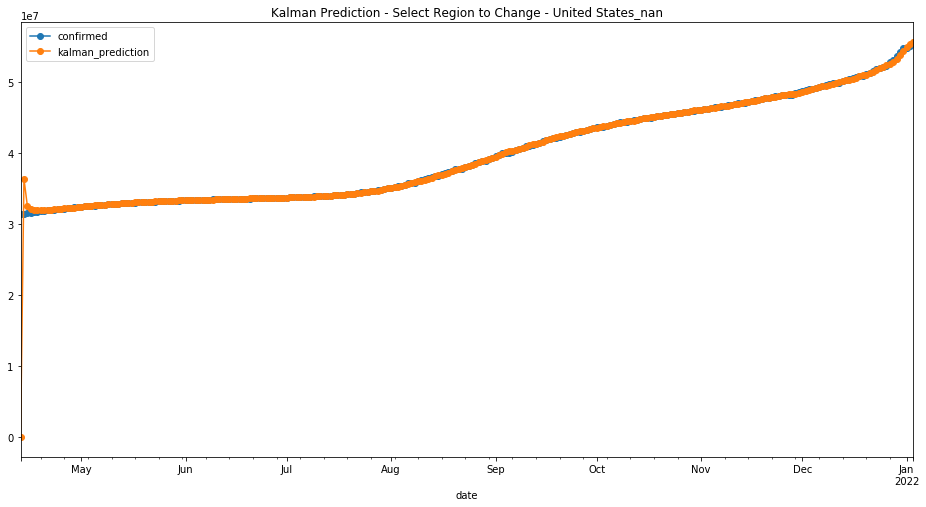

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
217  Russia_nan  4.087699e+11  639351.169997  44954.532075


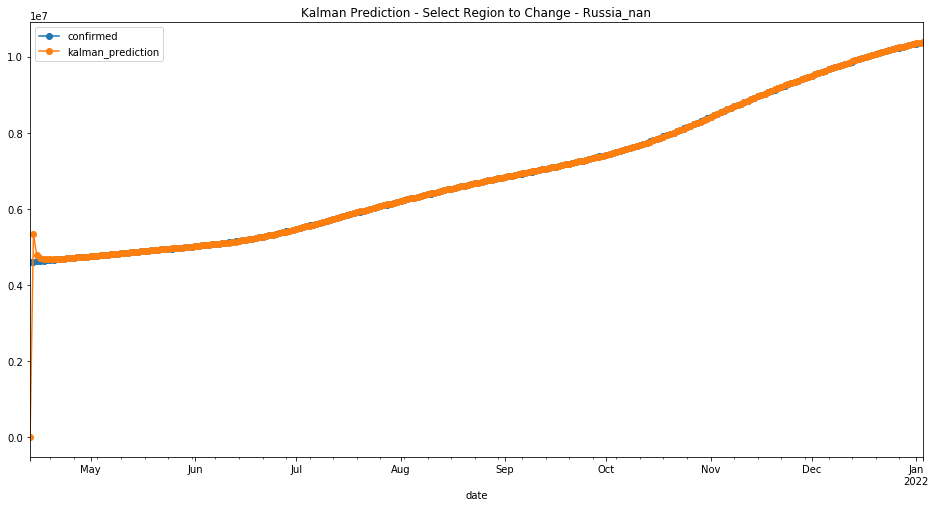

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
30  Brazil_nan  1.896128e+12  1.377000e+06  109639.822642


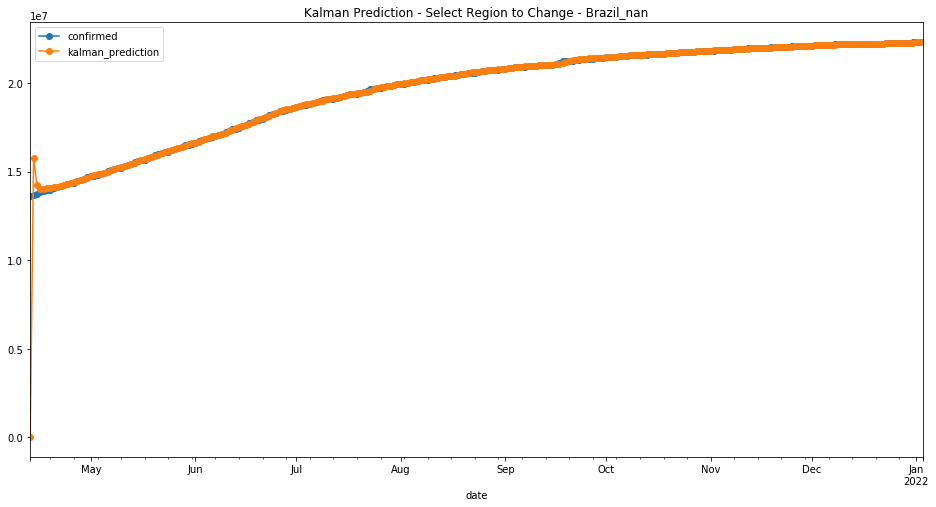

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
269  United Kingdom_nan  6.829235e+11  826391.847033  64024.641509


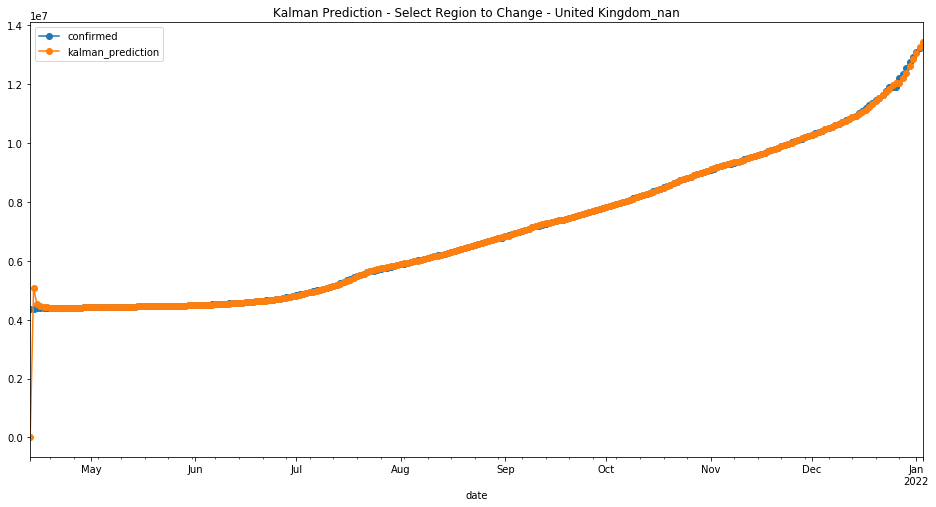

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxxy2fq43
  JVM stdout: /tmp/tmpxxy2fq43/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxxy2fq43/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 2 months and 7 days !!!
H2O cluster name:           H2O_from_python_unknownUser_6pvgh2
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2021-12-10
last_train_date= 2022-01-02
first_bootstrap_date= 2021-12-25
boost_bootstrap_date= 2021-12-30
first_test_date= 2021-12-24
last_test_date= 2022-01-03
first_valid_date= 2022-01-01


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   158681.0     157895 2021-12-25  Afghanistan_nan
1   158690.0     157951 2021-12-26  Afghanistan_nan
2   158735.0     157967 2021-12-27  Afghanistan_nan
3   158757.0     157998 2021-12-28  Afghanistan_nan
4   158790.0     158037 2021-12-29  Afghanistan_nan
5   158826.0     158056 2021-12-30  Afghanistan_nan
6   158852.0     158084 2021-12-31  Afghanistan_nan
7   158880.0     158107 2022-01-01  Afghanistan_nan
8   158902.0     158189 2022-01-02  Afghanistan_nan
9   158974.0          0 2022-01-03  Afghanistan_nan
10  207928.0     207542 2021-12-25      Albania_nan
11  208259.0     207709 2021-12-26      Albania_nan
12  208440.0     207709 2021-12-27      Albania_nan
13  208451.0     208352 2021-12-28      Albania_nan
14  209014.0     208899 2021-12-29      Albania_nan
15  209528.0     208899 2021-12-30      Albania_nan
16  209646.0     210224 2021-12-31      Albania_nan
17  210888.0     210224 2022-01-01      Albania_nan
18  210980.0     210885 2022-01-02      Albania_nan
19  211761.0          0 2022-01-03      Albania_nan
20  217087.0     216376 2021-12-25      Algeria_nan
21  217380.0     216637 2021-12-26      Algeria_nan
22  217660.0     216930 2021-12-27      Algeria_nan
23  217946.0     217265 2021-12-28      Algeria_nan
24  218276.0     217647 2021-12-29      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  616784.0     616352 2021-12-30  Azerbaijan_nan
176  617263.0     616947 2021-12-31  Azerbaijan_nan
177  617853.0     617311 2022-01-01  Azerbaijan_nan
178  618180.0     617679 2022-01-02  Azerbaijan_nan
179  618569.0          0 2022-01-03  Azerbaijan_nan
180   23782.0      23539 2021-12-25     Bahamas_nan
181   24246.0      23539 2021-12-26     Bahamas_nan
182   24248.0      23539 2021-12-27     Bahamas_nan
183   24216.0      23539 2021-12-28     Bahamas_nan
184   24199.0      24204 2021-12-29     Bahamas_nan
185   23056.0      24269 2021-12-30     Bahamas_nan
186   24834.0      24476 2021-12-31     Bahamas_nan
187   24782.0      24476 2022-01-01     Bahamas_nan
188   25272.0      25285 2022-01-02     Bahamas_nan
189   24022.0          0 2022-01-03     Bahamas_nan
190  279320.0     279518 2021-12-25     Bahrain_nan
191  279579.0     279805 2021-12-26     Bahrain_nan
192  279889.0     280109 2021-12-27     Bahrain_nan
193  280215.0     280482 2021-12-28     Bahrain_nan
194  280615.0     280876 2021-12-29     Bahrain_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date       region
220   692839.0     692601 2021-12-25  Belarus_nan
221   694288.0     693584 2021-12-26  Belarus_nan
222   695316.0     694226 2021-12-27  Belarus_nan
223   695916.0     694727 2021-12-28  Belarus_nan
224   696316.0     696220 2021-12-29  Belarus_nan
225   697851.0     697600 2021-12-30  Belarus_nan
226   699044.0     699110 2021-12-31  Belarus_nan
227   700635.0     700421 2022-01-01  Belarus_nan
228   701954.0     701192 2022-01-02  Belarus_nan
229   702712.0          0 2022-01-03  Belarus_nan
230  2044807.0    2038111 2021-12-25  Belgium_nan
231  2043391.0    2038111 2021-12-26  Belgium_nan
232  2042885.0    2052871 2021-12-27  Belgium_nan
233  2060399.0    2062836 2021-12-28  Belgium_nan
234  2067760.0    2075781 2021-12-29  Belgium_nan
235  2082736.0    2089657 2021-12-30  Belgium_nan
236  2097666.0    2105343 2021-12-31  Belgium_nan
237  2115410.0    2105343 2022-01-01  Belgium_nan
238  2113217.0    2105343 2022-01-02  Belgium_nan
239  2114387.0          0 2022-01-03  Belgium_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  79213392677.33385
# MSE on the validation data =  47555226560886.45
# R^2 on the training data =  0.9989226908426988
# R^2 on the validation data =  0.43021028585761656


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1641194898917_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 79213392677.33385
RMSE: 281448.7389869314
MAE: 15926.005600886672
RMSLE: 0.4078367211908509
Mean Residual Deviance: 79213392677.33385

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 47555226560886.45
RMSE: 6896029.767981462
MAE: 1946599.7847977765
RMSLE: 8.120452188348004
Mean Residual Deviance: 47555226560886.45
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2022-01-03 07:28:26  0.095 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2022-01-03 07:28:27  0.521 sec   1.0                282242.7579104194   38008.740507962124  79660974392.8796     6879143.838280214   1950811.982516452   47322619947748.63
     2022-01-03 07:28:27  0.678 sec   2.0                510056.1229312157   45056.65246185071   260157248539.62338   6914970.963157637   1955360.711837734   47816823421313.26
     2022-01-03 07:28:27  0.799 sec   3.0                451243.2176394338   45125.750090425434  203620441465.58942   6933001.108961445   1940050.0633300005  48066504376860.63
     2022-01-03 07:28:27  0.930 sec   4.0                433008.03960980853  43439.884097660484  187495962366.72952   6942547.1272521075  1938408.2118085397  48198960614116.484
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2022-01-03 07:28:38  12.154 sec  194.0              271884.0011043041   17081.633725896674  73920910056.48523    6901367.4809080325  1953396.6768286533  47628873106534.88
     2022-01-03 07:28:42  16.164 sec  279.0              275169.79868784954  16789.69043244503   75718418109.91164    6886240.274724405   1947899.3381029232  47420305121236.45
     2022-01-03 07:28:46  20.187 sec  363.0              276564.2193443541   16218.073161577538  76487767421.552      6885202.679797176   1946634.9589171668  47406015941886.22
     2022-01-03 07:28:50  24.205 sec  446.0              280085.2904623907   15995.518037876853  78447769933.40178    6893030.480930387   1946719.3905501154  47513869211035.41
     2022-01-03 07:28:53  26.986 sec  500.0              281448.7389869314   15926.005600886672  79213392677.33385    6896029.767981462   1946599.7847977765  47555226560886.45


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  1.17162e+20            1                    0.352174
last_day           9.6697e+19             0.825329             0.290659
region             6.70515e+19            0.572298             0.201548
7_day_change       2.27289e+19            0.193996             0.0683204
3_day_change       1.24346e+19            0.106132             0.0373768
1_day_change       8.04491e+18            0.0686649            0.024182
infected_rate      4.86992e+18            0.0415657            0.0146384
7_day_change_rate  1.85345e+18            0.0158196            0.00557124
3_day_change_rate  1.32081e+18            0.0112734            0.0039702
1_day_change_rate  5.18768e+17            0.00442779           0.00155935

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         1.171618e+20           1.000000    0.352174
1           last_day         9.669700e+19           0.825329    0.290659
2             region         6.705145e+19           0.572298    0.201548
3       7_day_change         2.272894e+19           0.193996    0.068320
4       3_day_change         1.243459e+19           0.106132    0.037377
5       1_day_change         8.044906e+18           0.068665    0.024182
6      infected_rate         4.869916e+18           0.041566    0.014638
7  7_day_change_rate         1.853449e+18           0.015820    0.005571
8  3_day_change_rate         1.320813e+18           0.011273    0.003970
9  1_day_change_rate         5.187678e+17           0.004428    0.001559

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


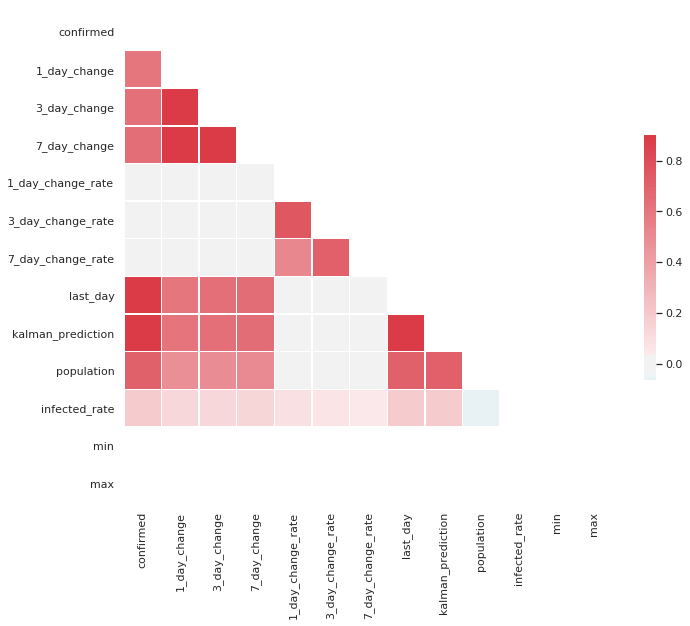

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.607218
3_day_change         0.629151
7_day_change         0.640307
1_day_change_rate    0.018983
3_day_change_rate    0.012521
7_day_change_rate    0.005263
last_day             0.994926
kalman_prediction    0.995786
population           0.707671
infected_rate        0.185945
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


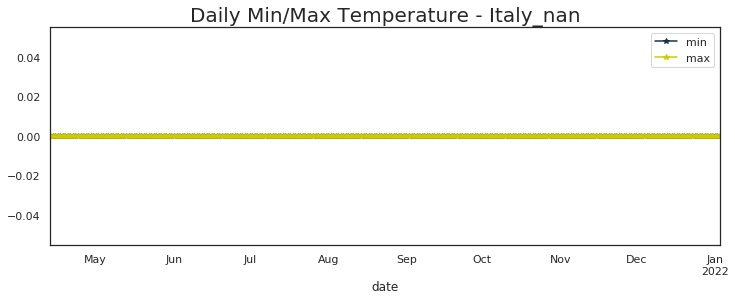

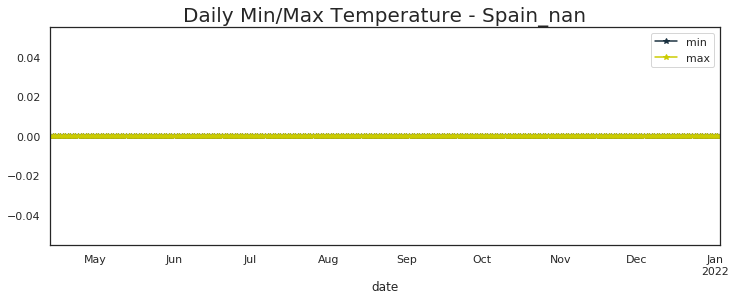

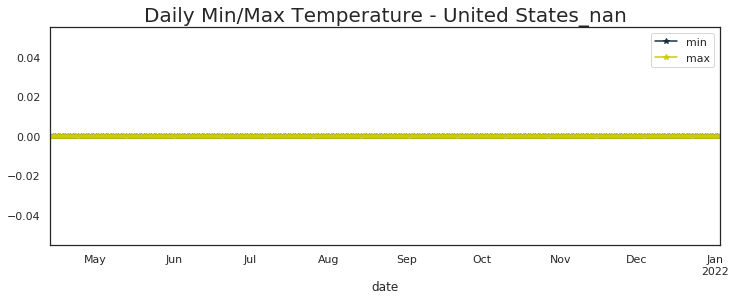

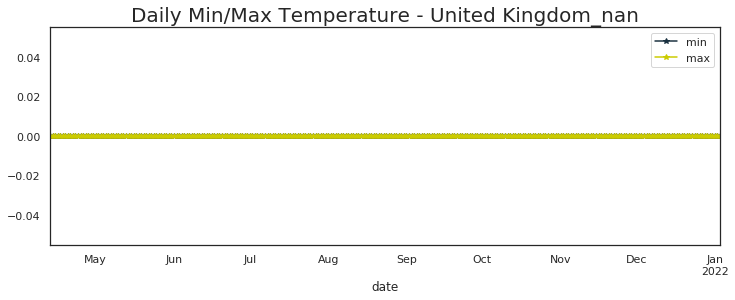

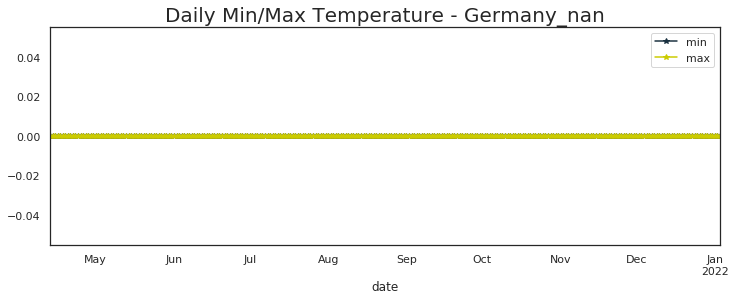

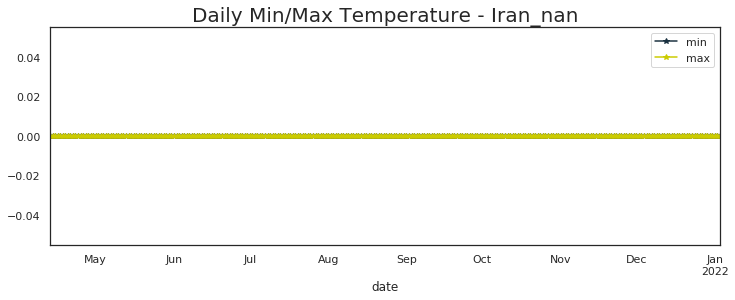

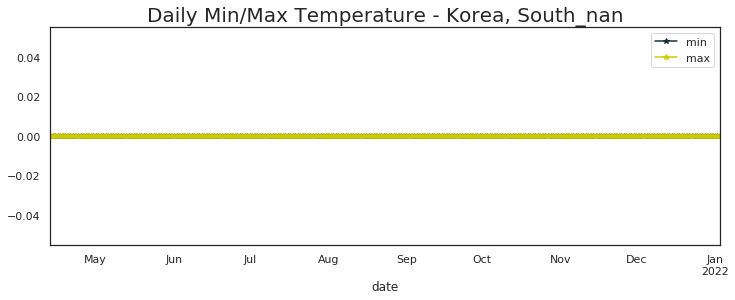

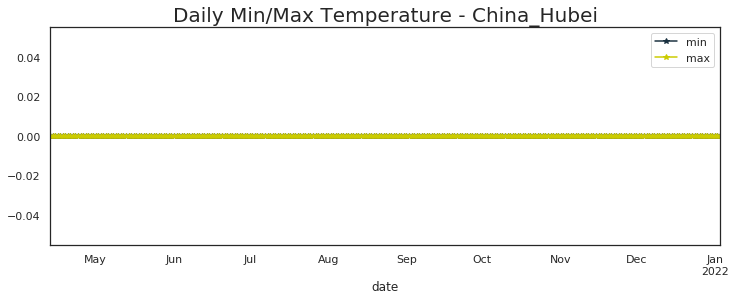

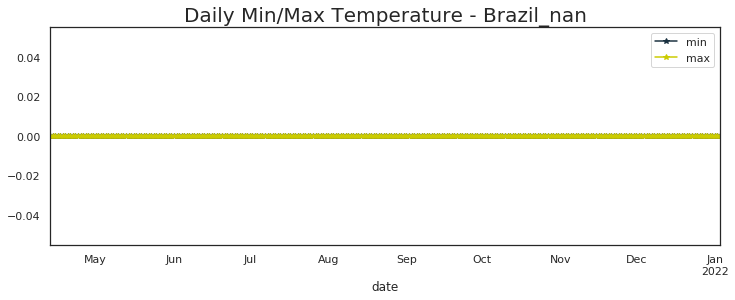

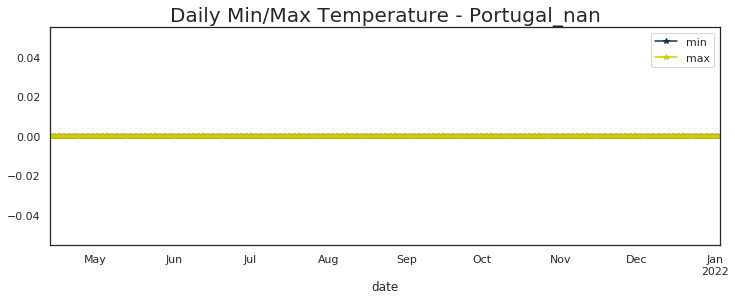

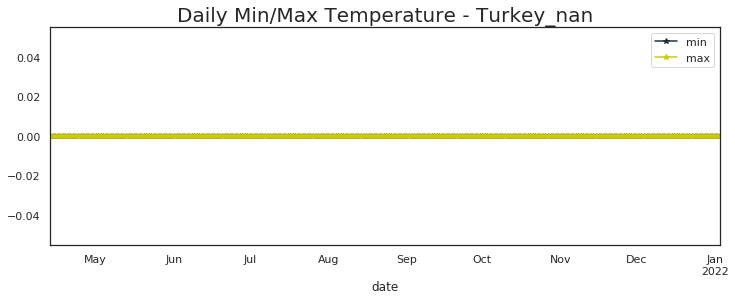

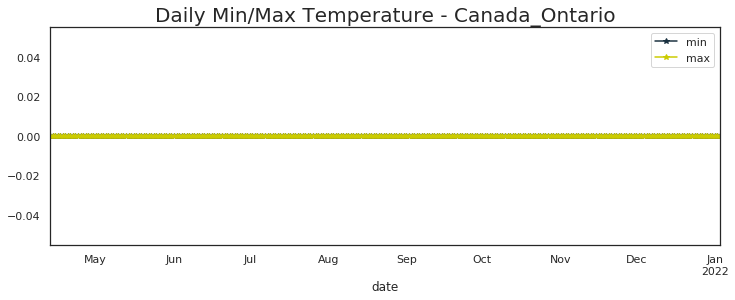

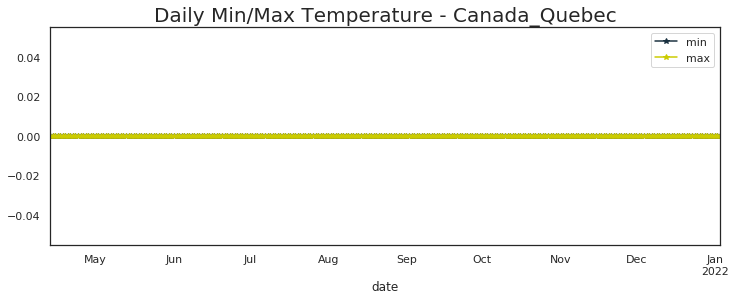

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
Russia_nan                  0.0  0.0
France_nan                  0.0  0.0
Turkey_nan                  0.0  0.0
Germany_nan                 0.0  0.0
Italy_nan                   0.0  0.0
Spain_nan                   0.0  0.0
Iran_nan                    0.0  0.0
Argentina_nan               0.0  0.0
Colombia_nan                0.0  0.0
Indonesia_nan               0.0  0.0
Poland_nan                  0.0  0.0
Mexico_nan                  0.0  0.0
Ukraine_nan                 0.0  0.0
South Africa_nan            0.0  0.0
Netherlands_nan             0.0  0.0
Philippines_nan             0.0  0.0
Malaysia_nan                0.0  0.0
Czechia_nan                 0.0  0.0
Peru_nan                    0.0  0.0
Thailand_nan                0.0  0.0
Be

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

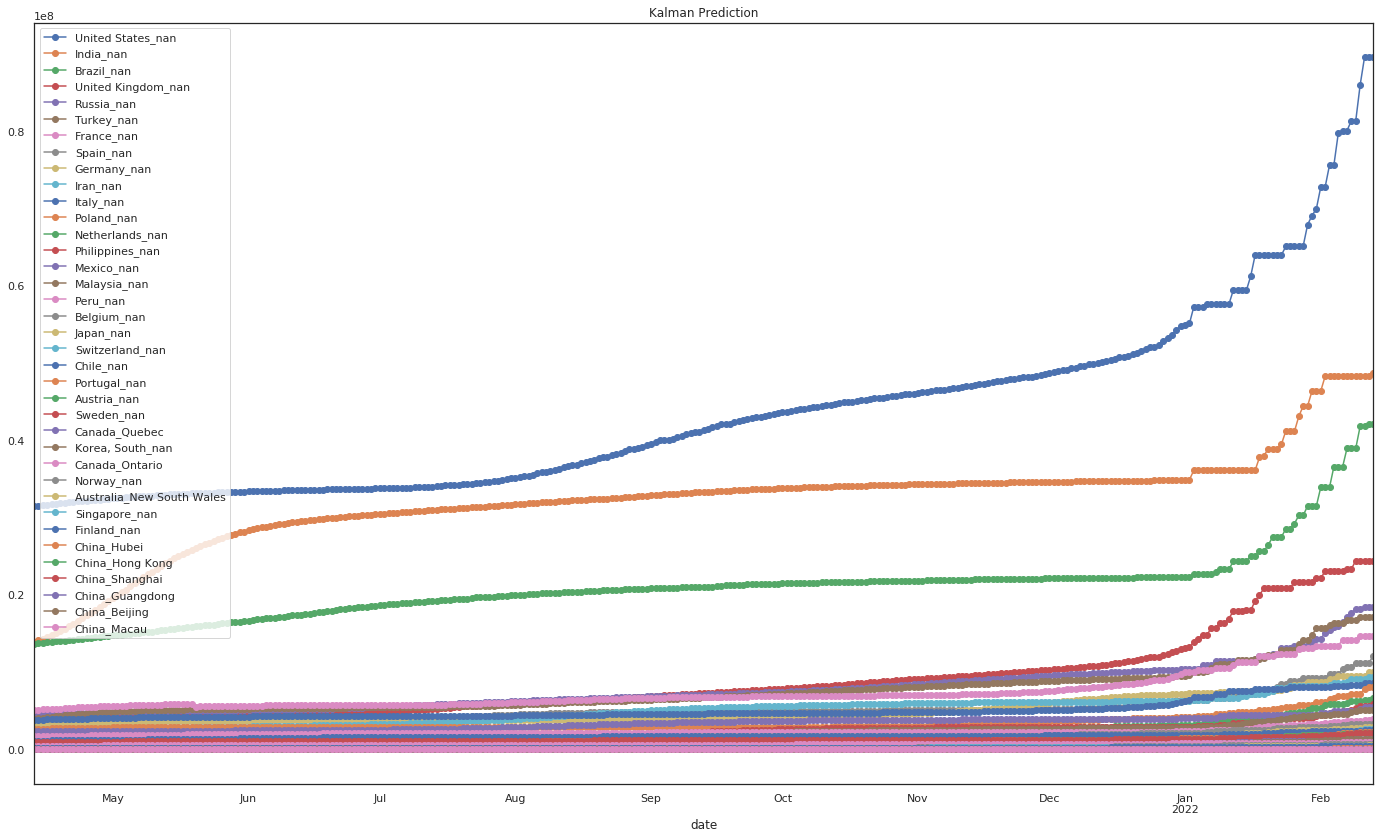

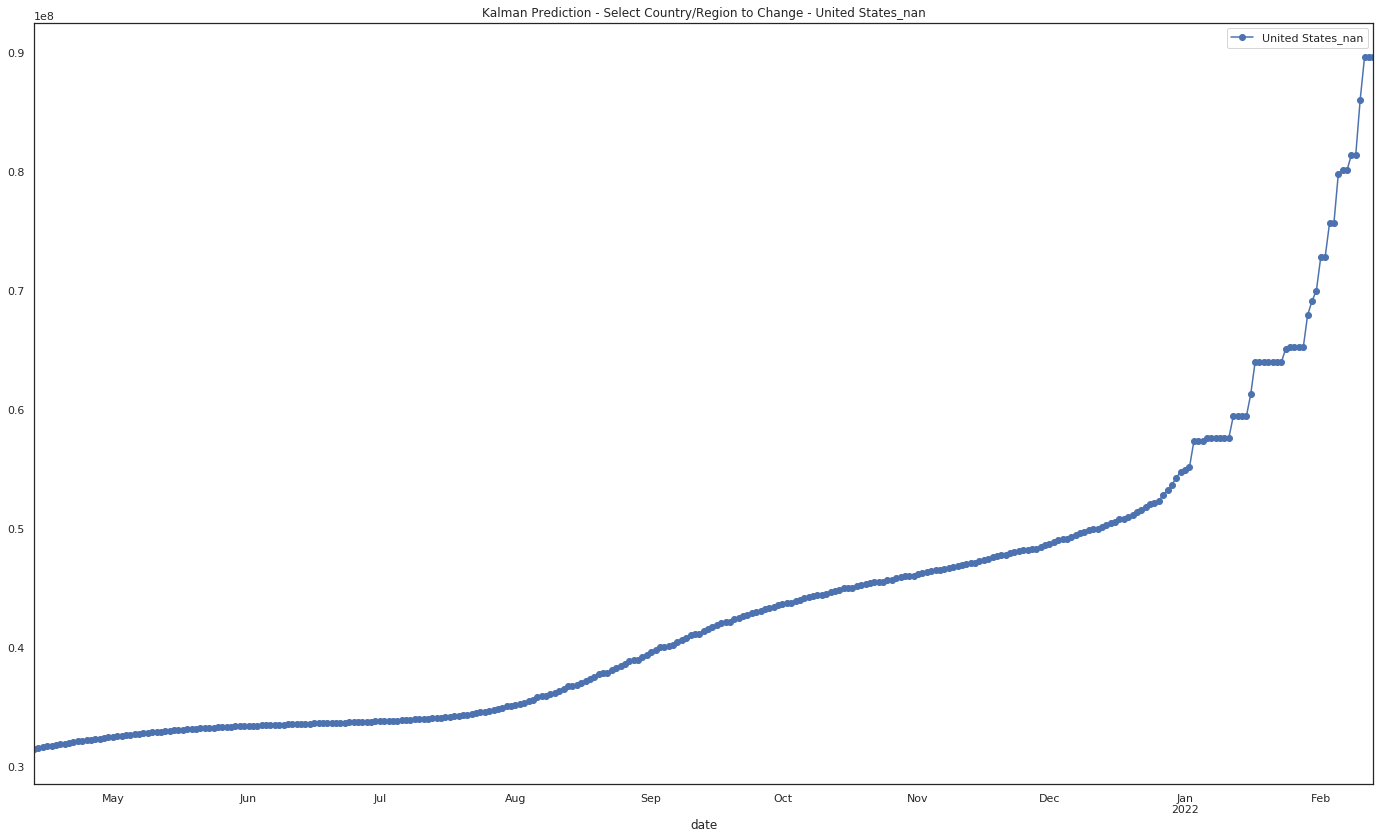

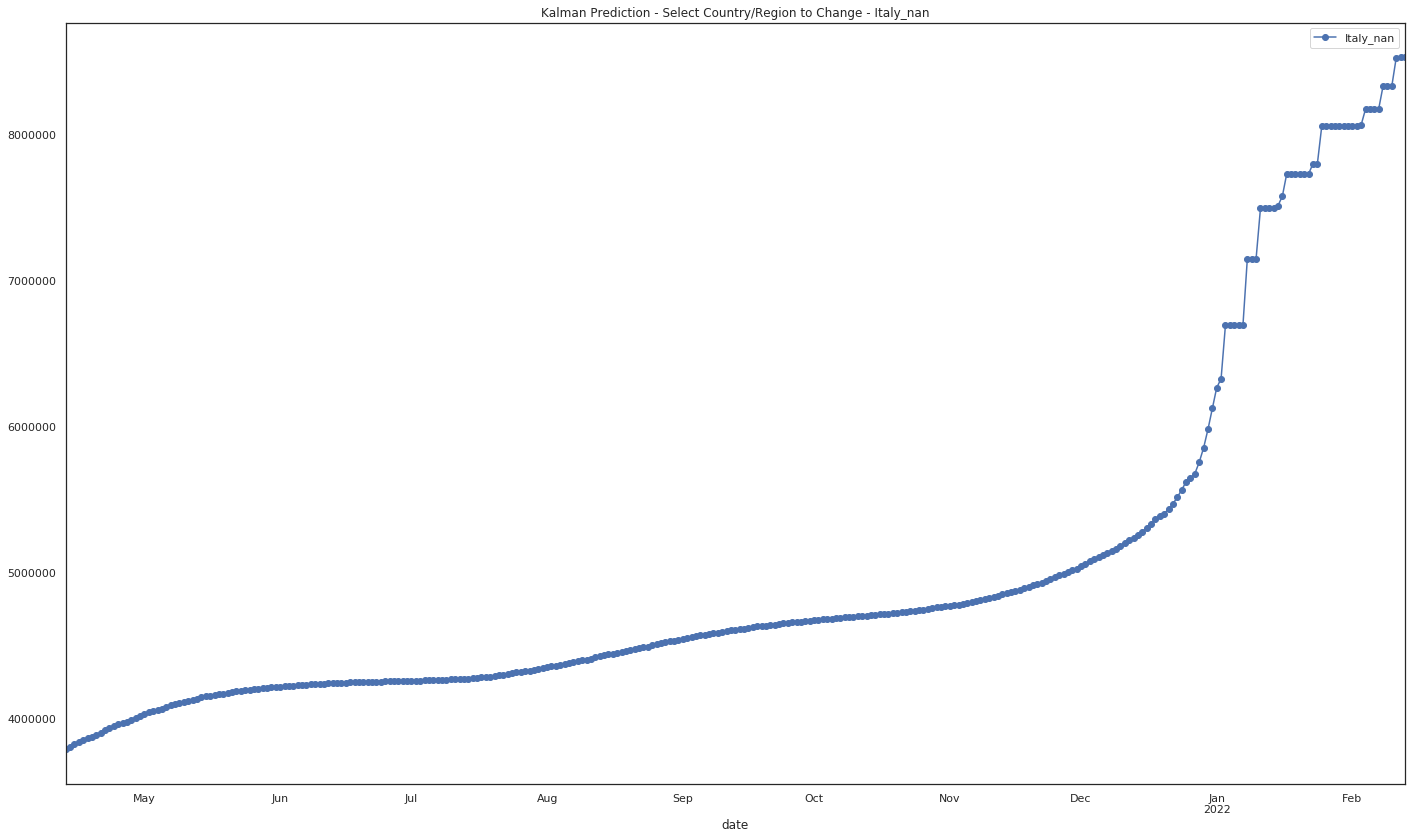

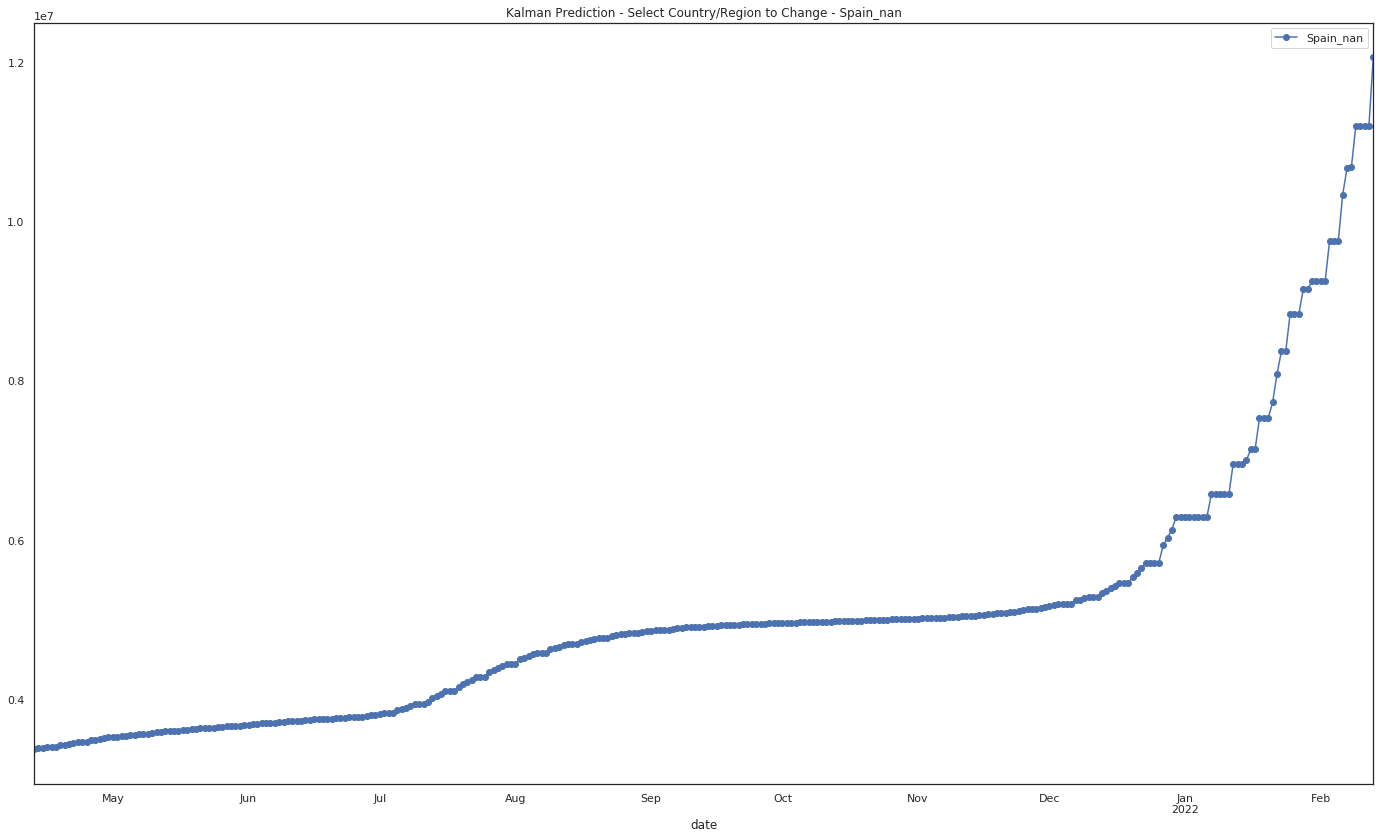

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


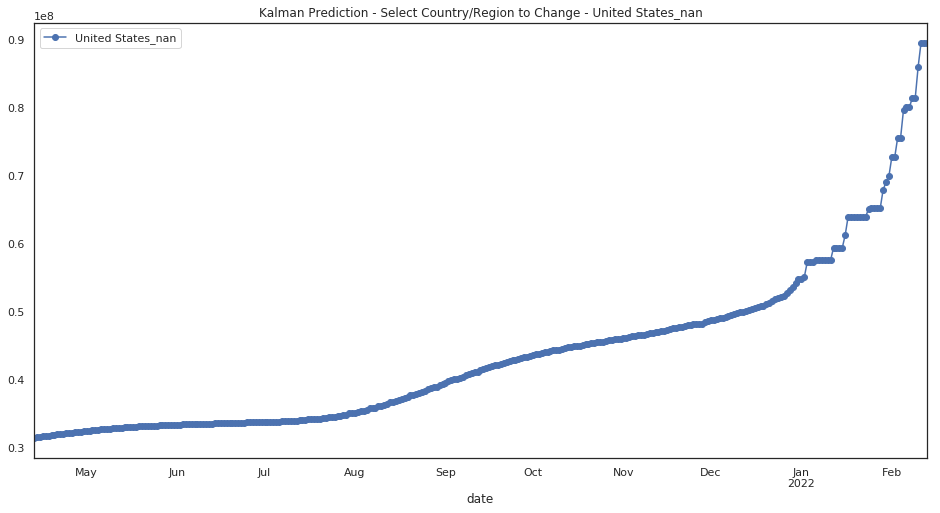

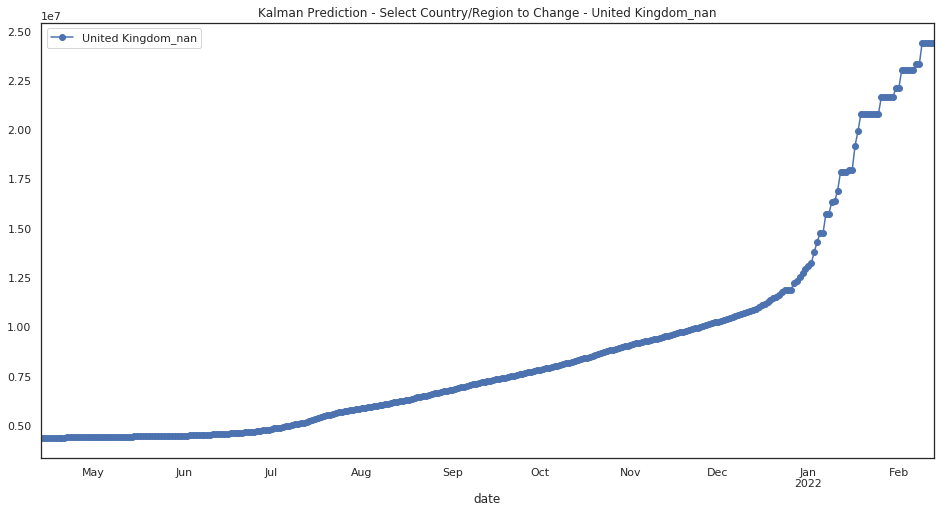

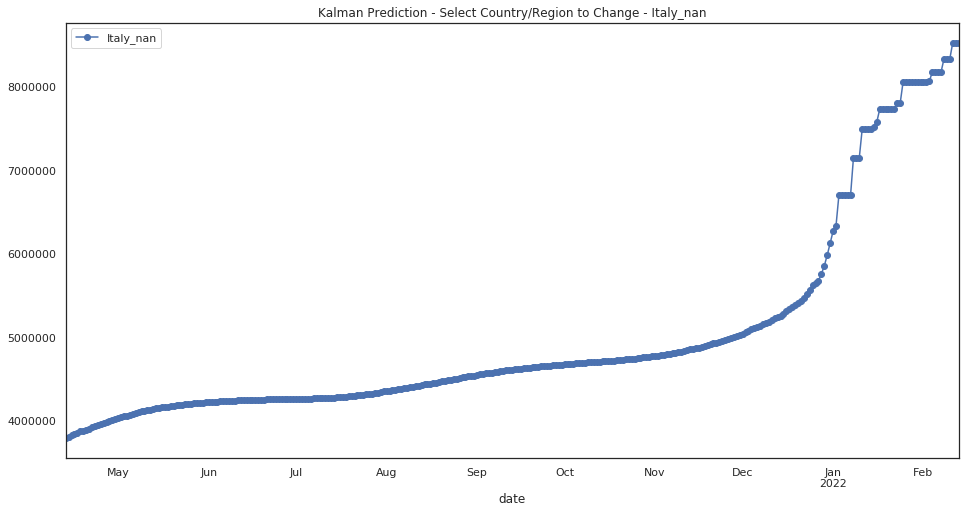

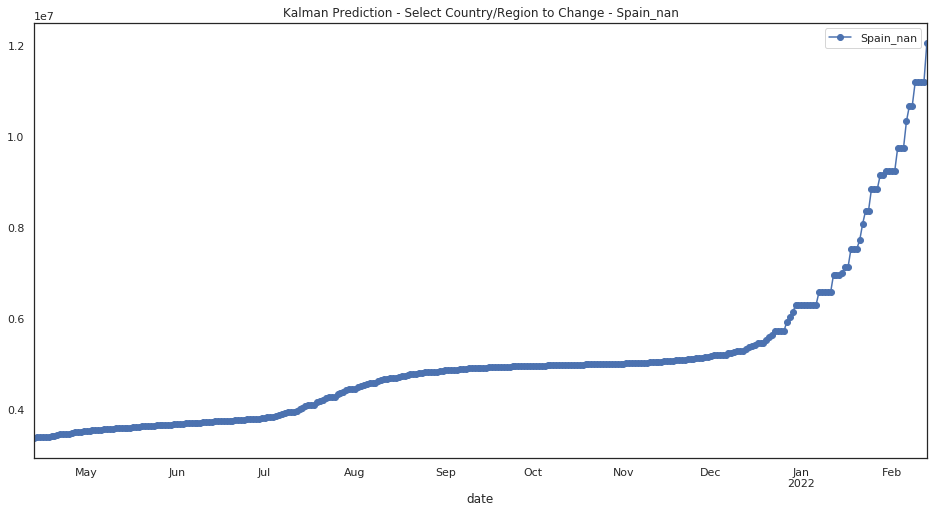

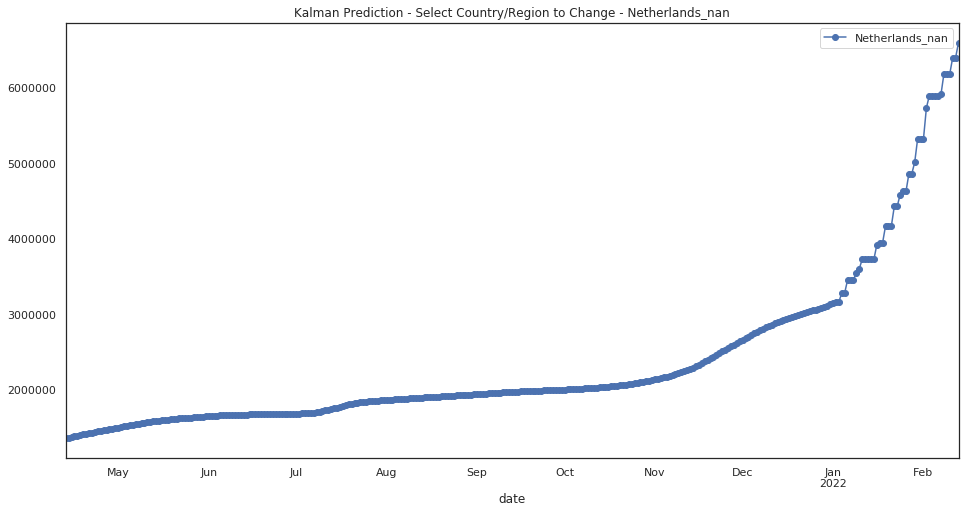

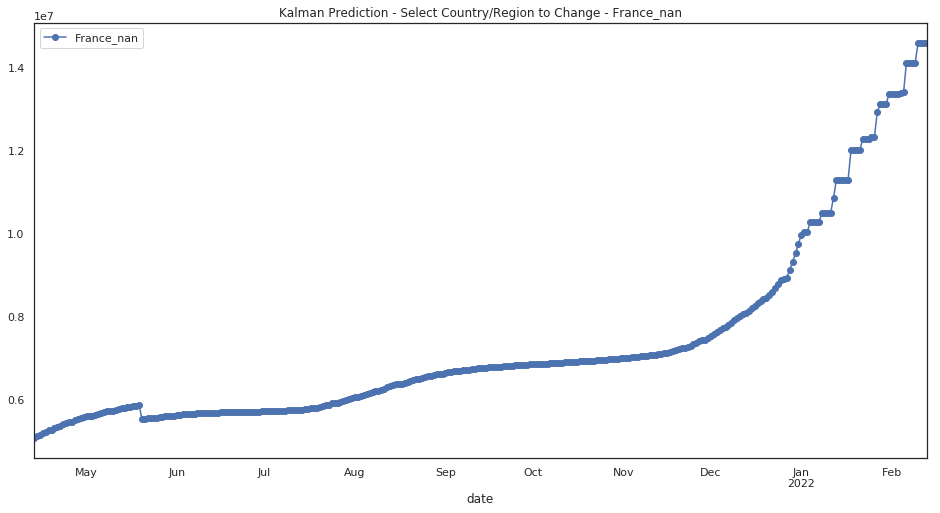

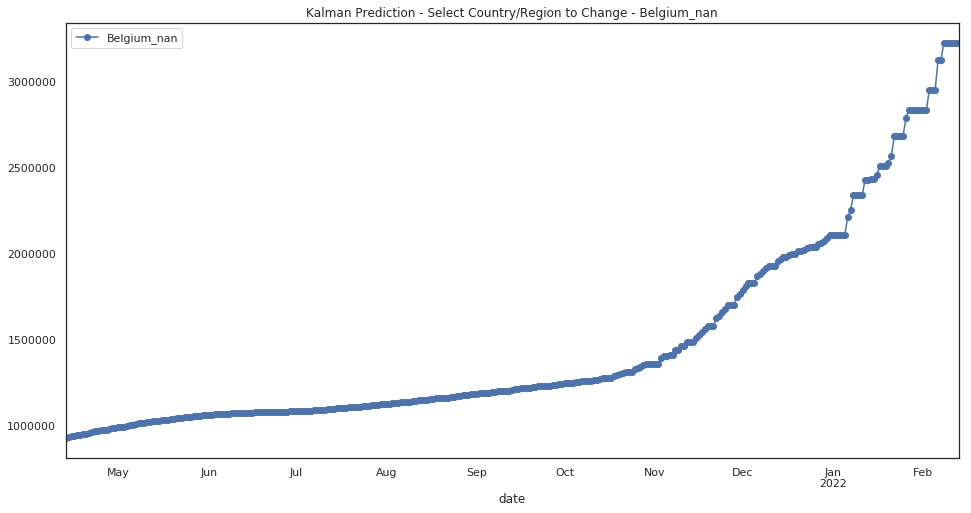

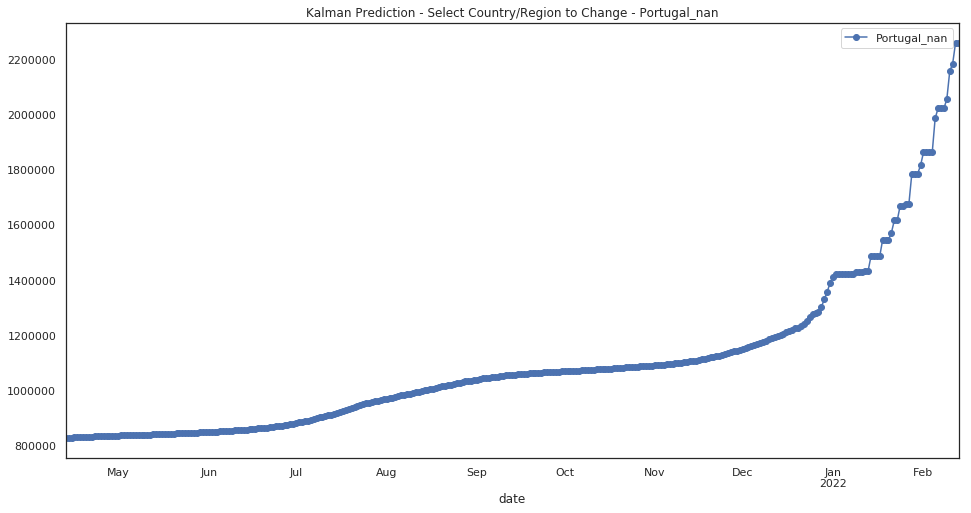

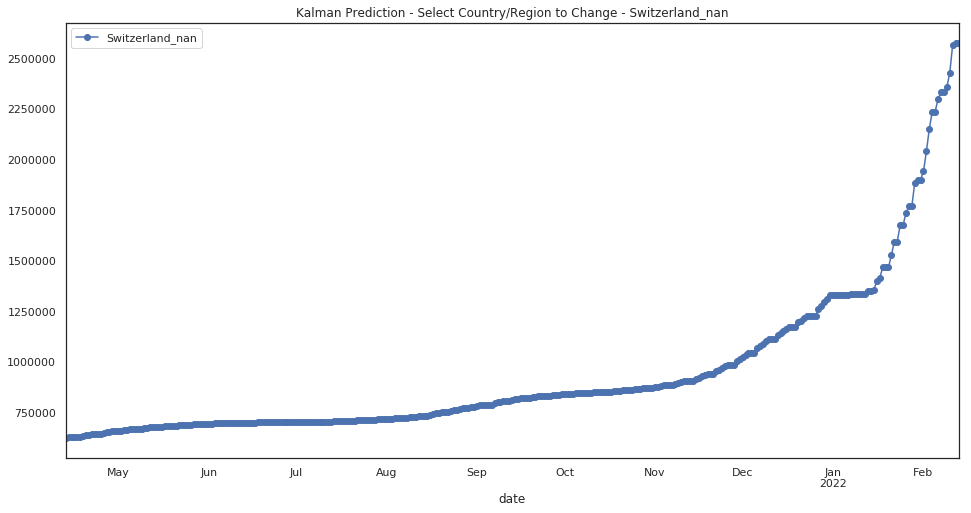

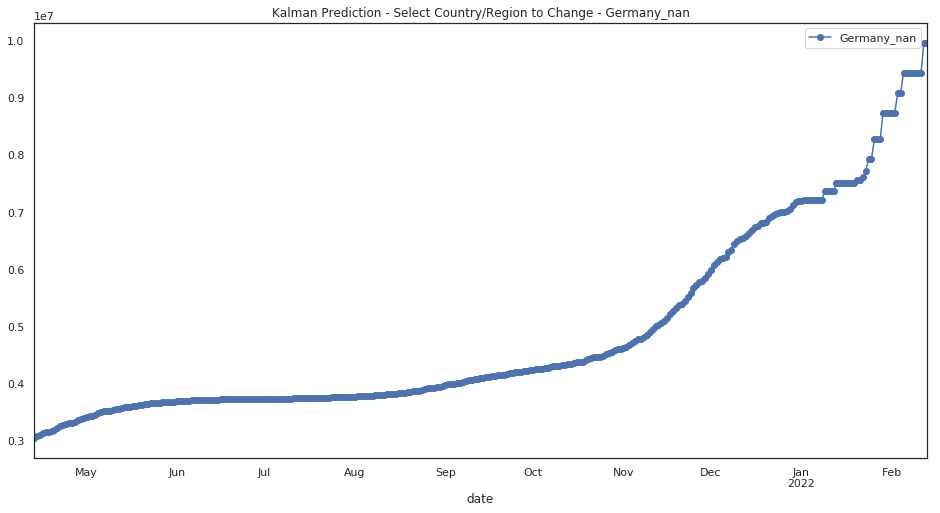

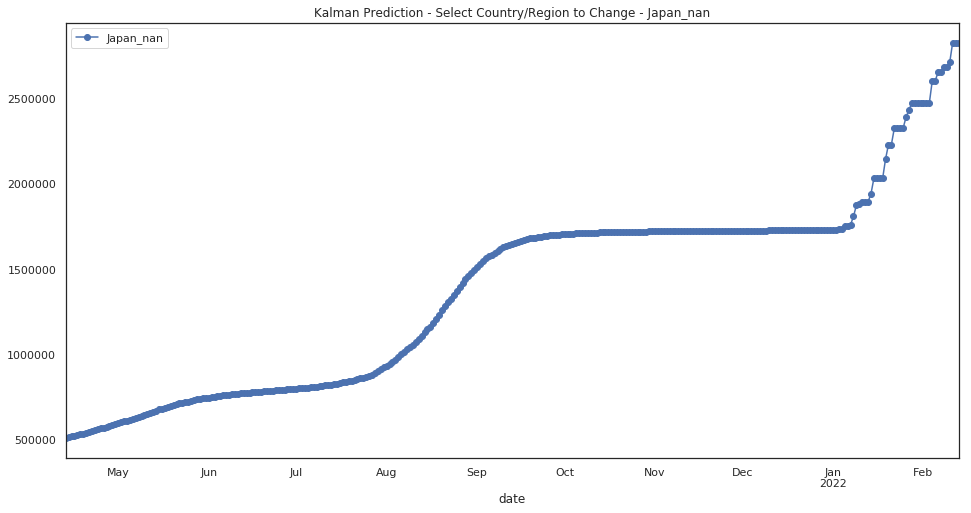

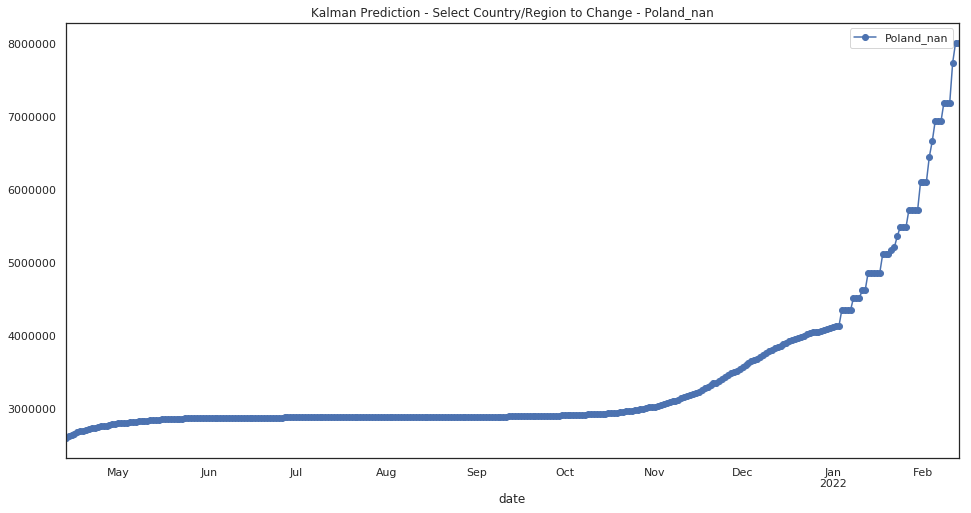

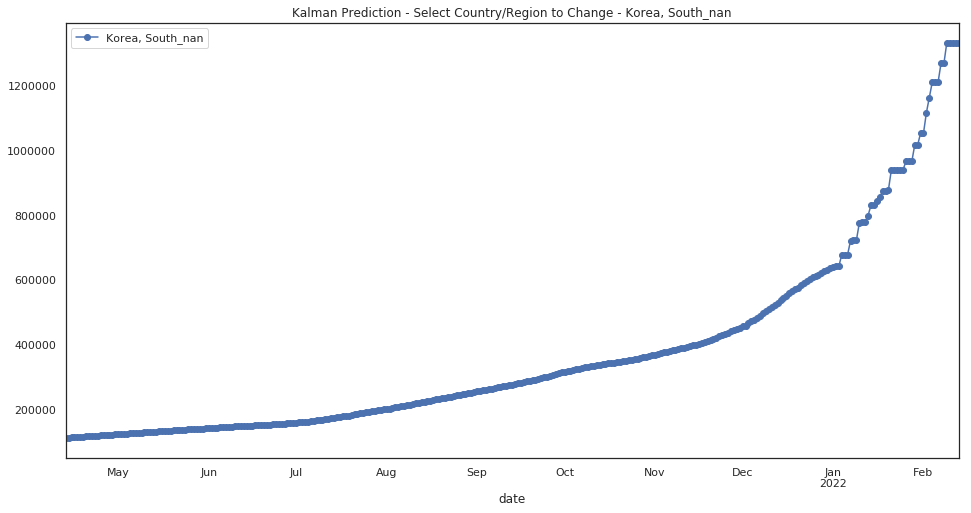

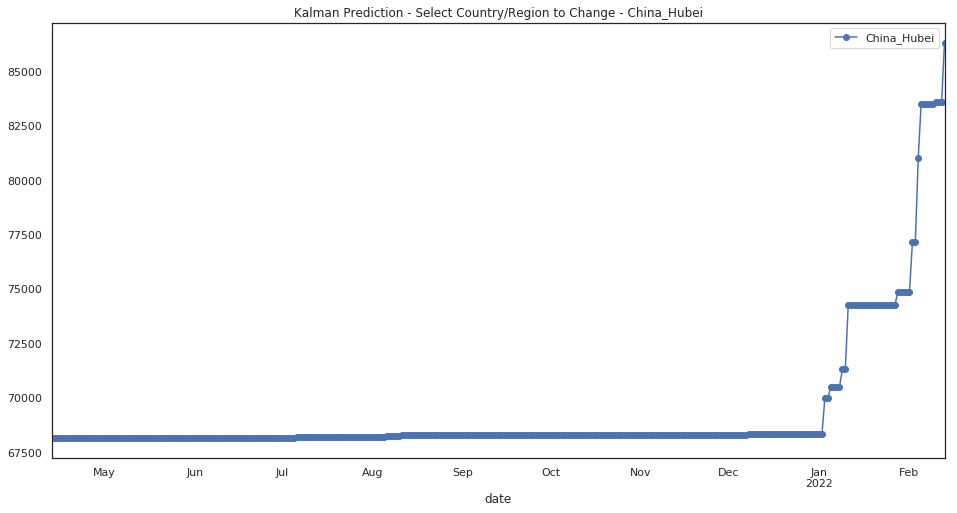

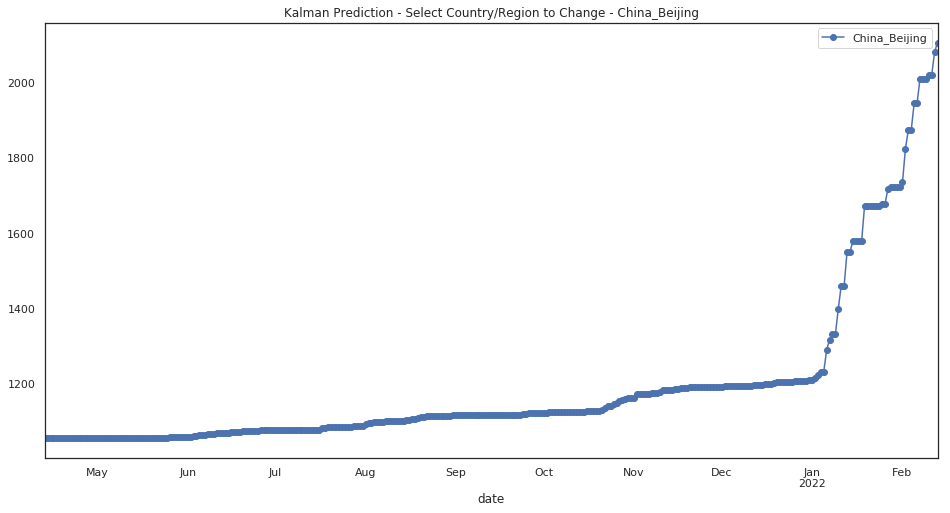

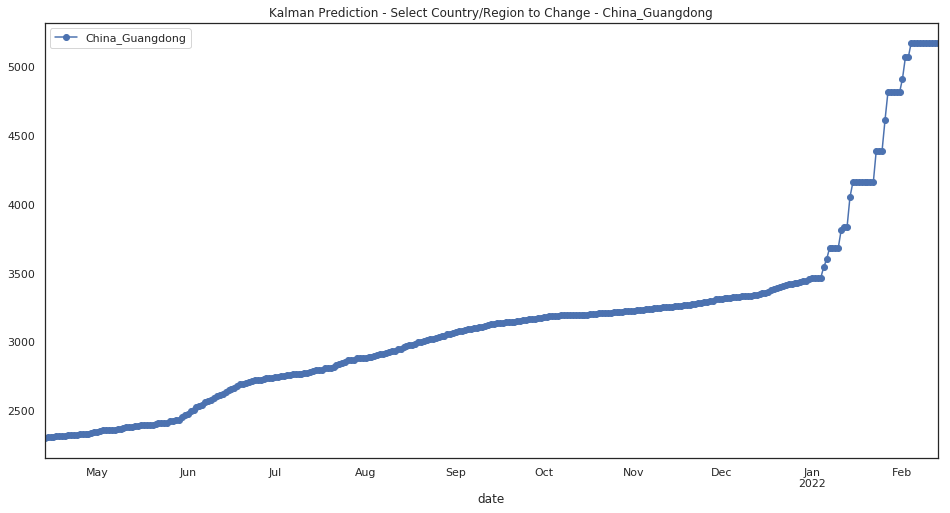

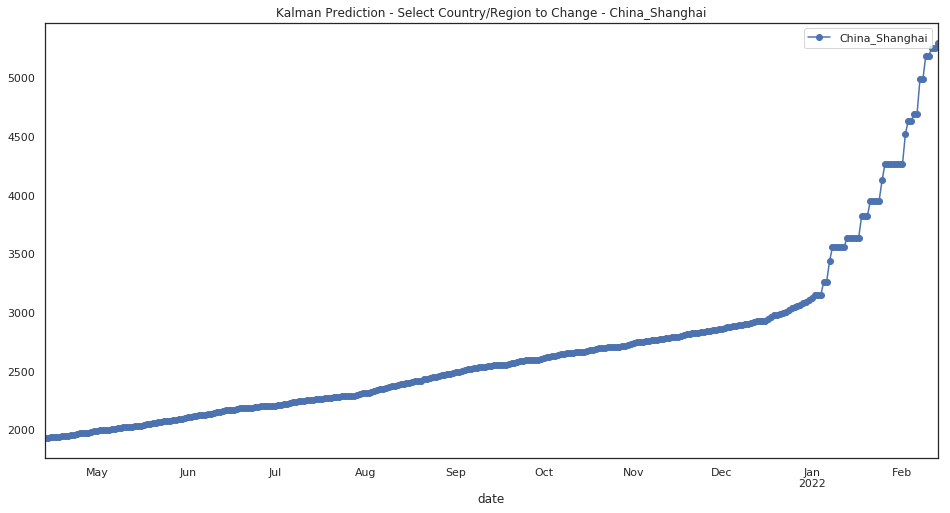

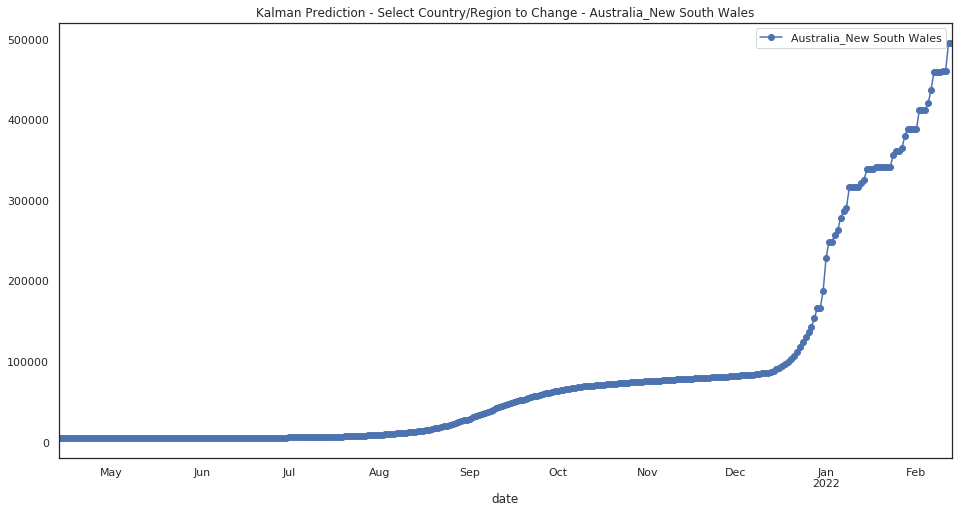

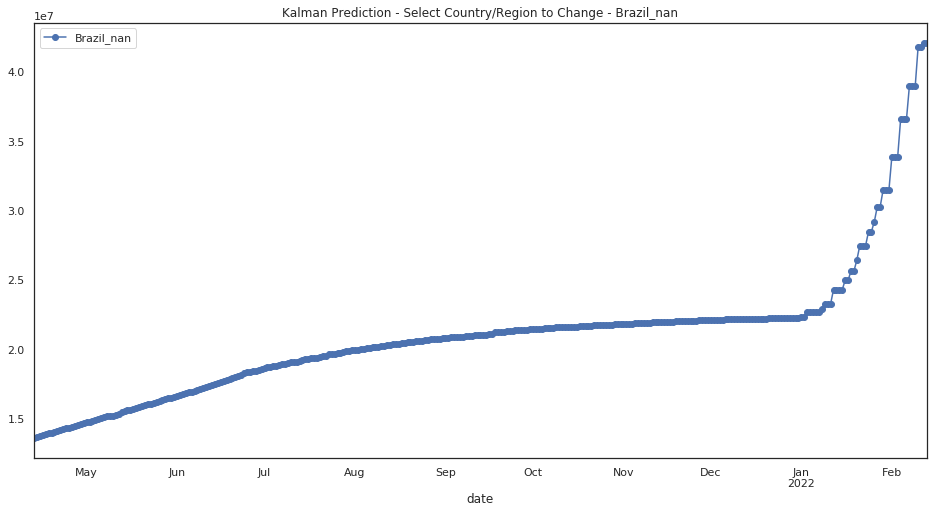

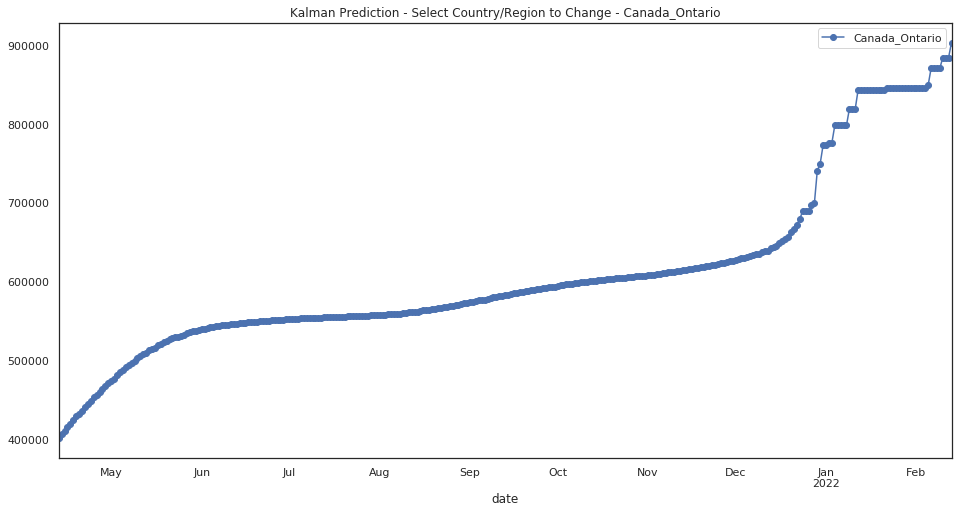

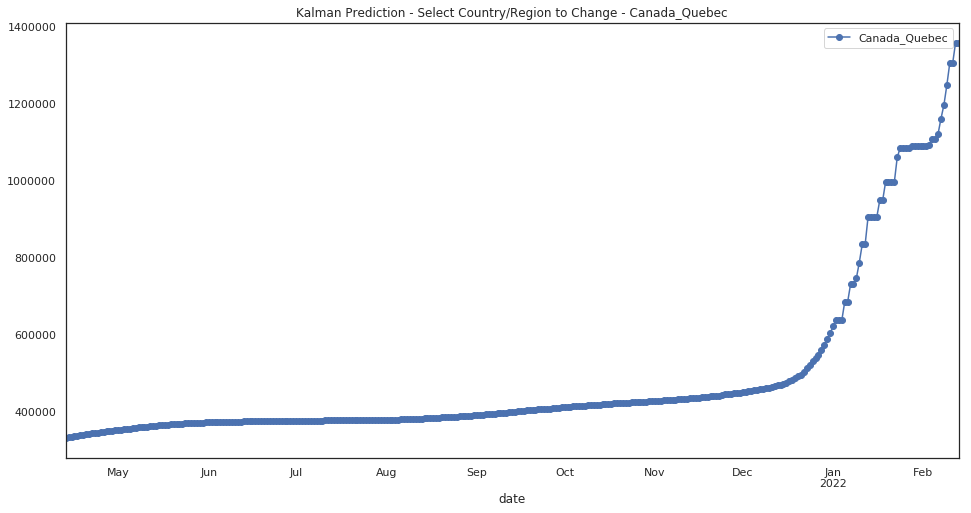

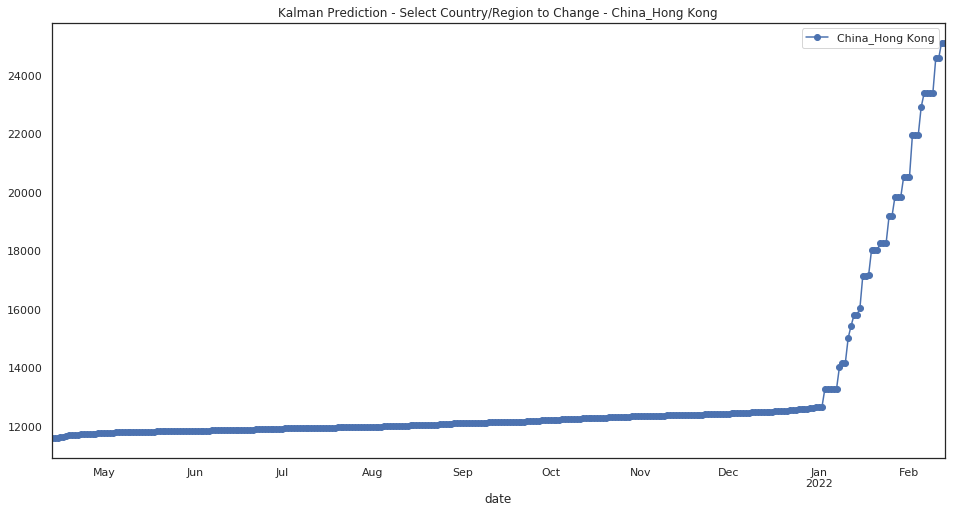

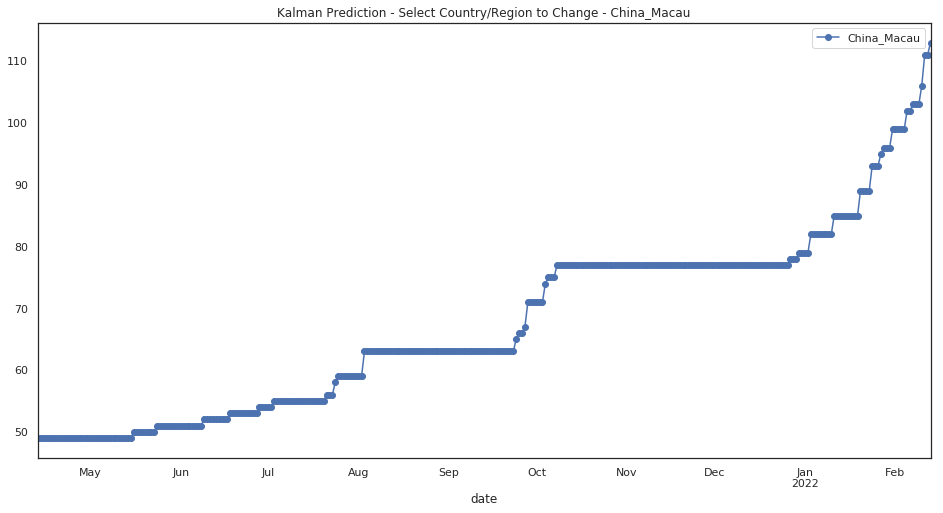

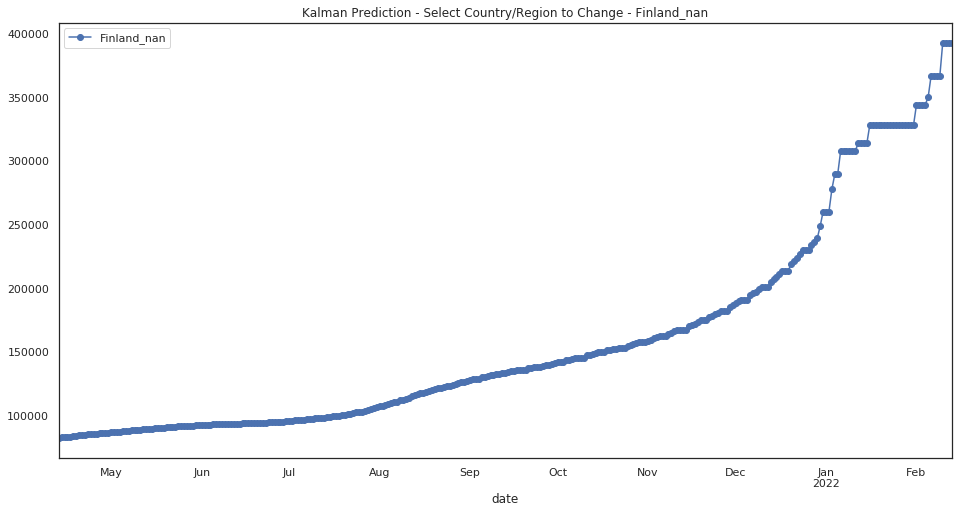

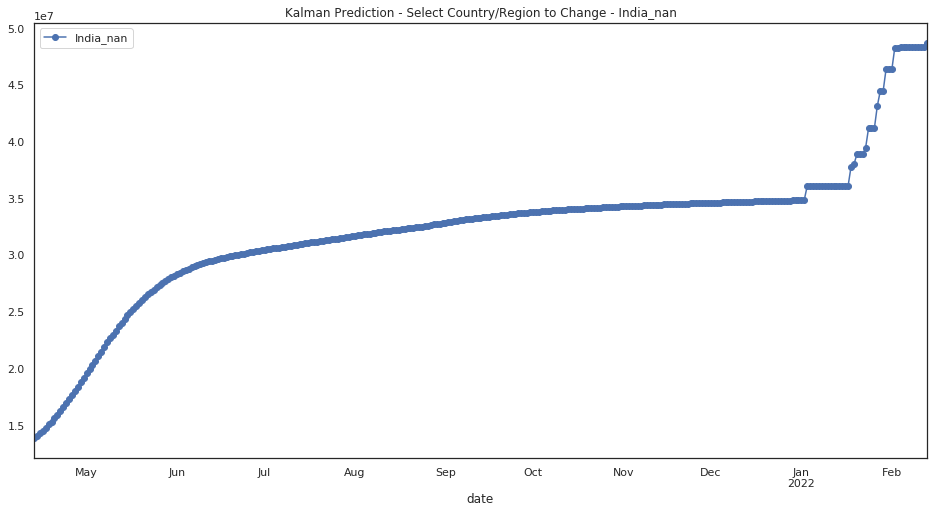

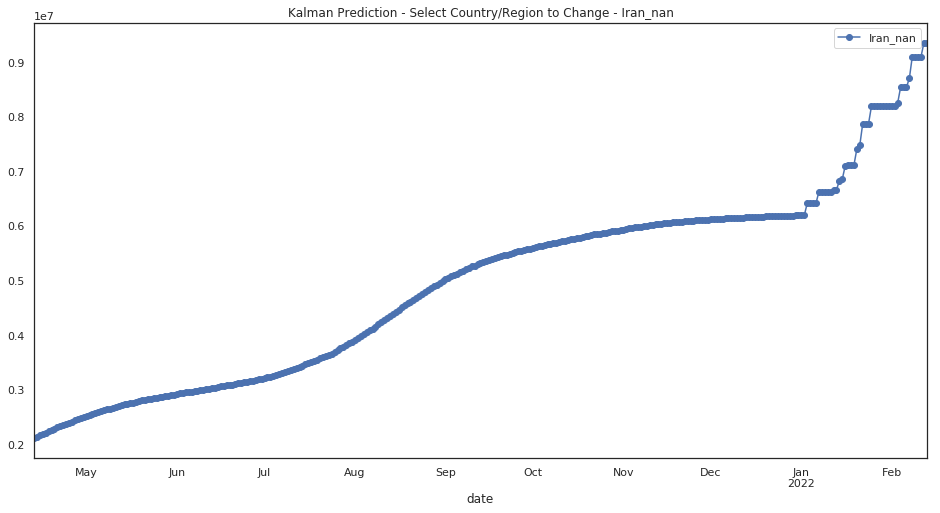

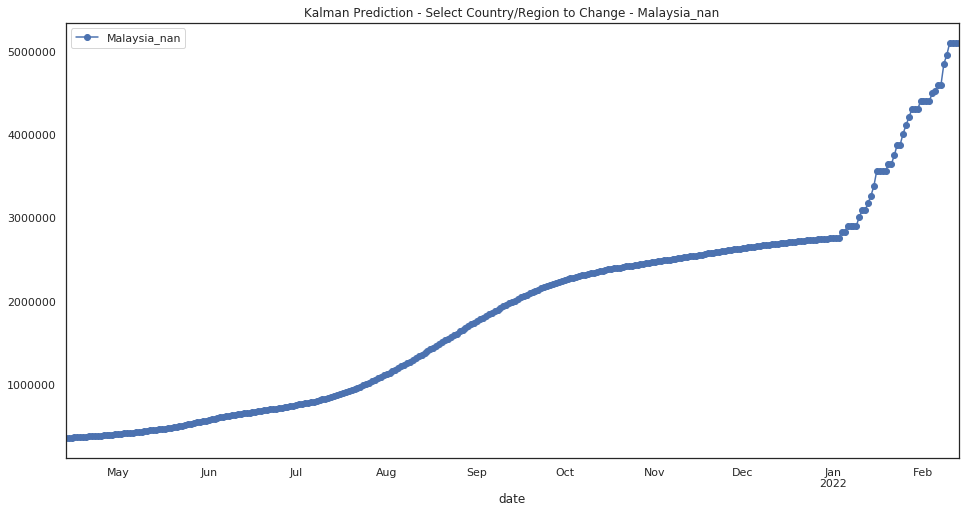

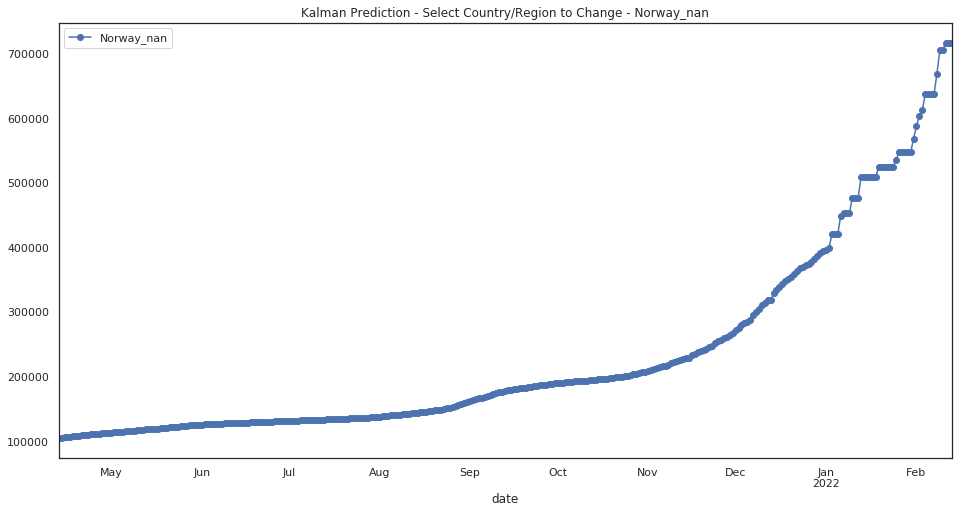

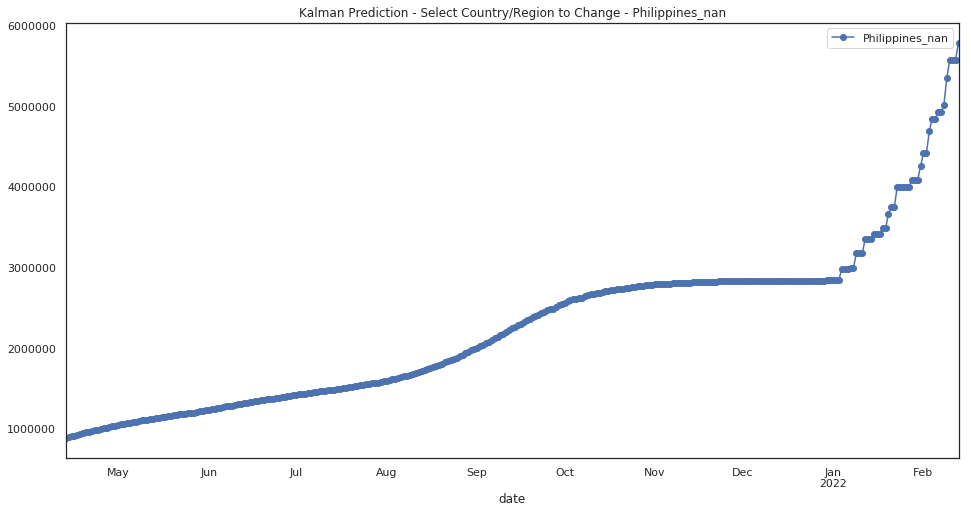

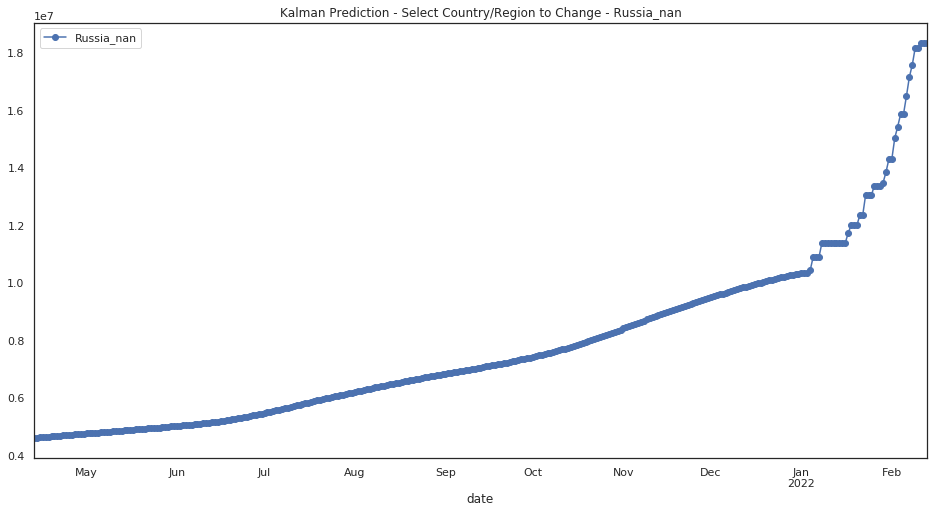

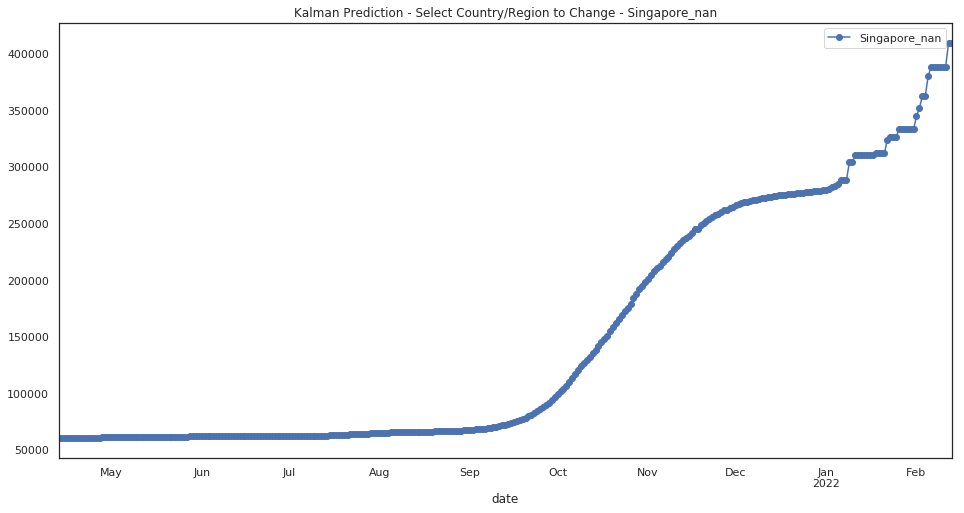

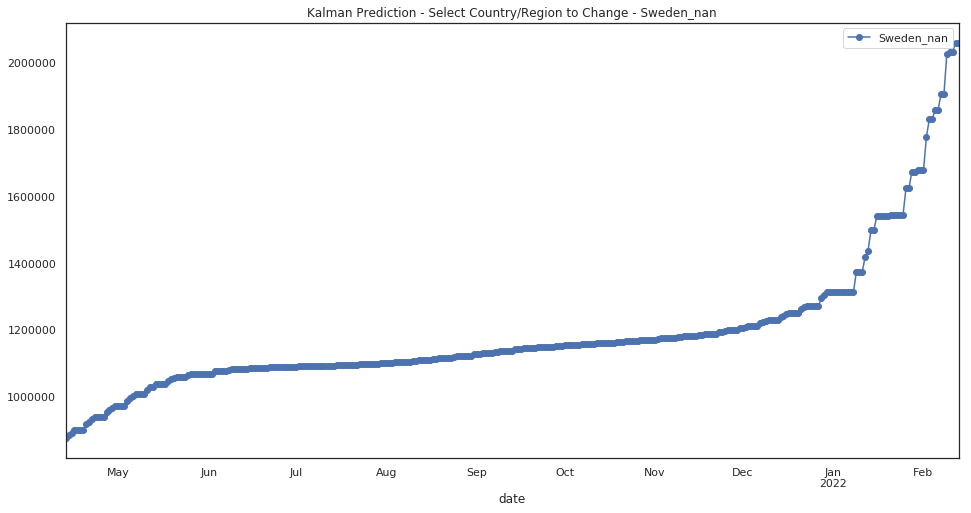

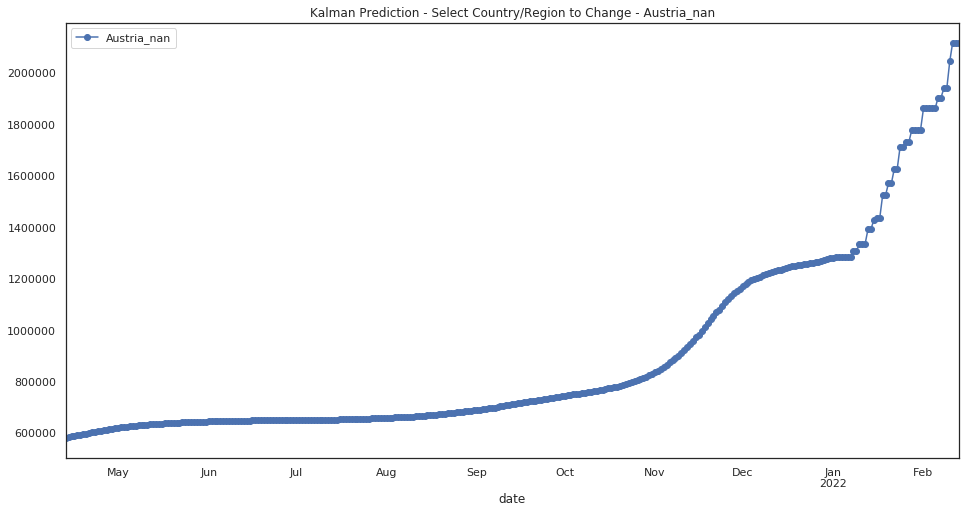

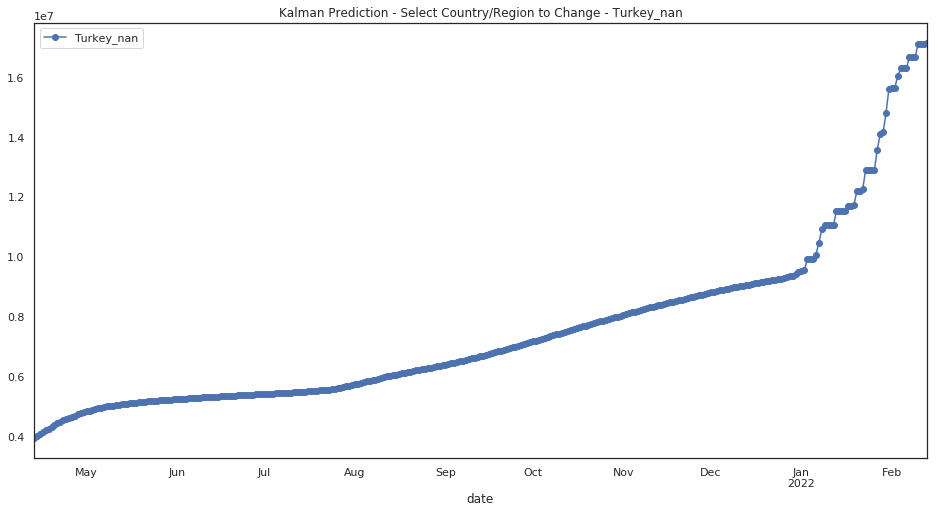

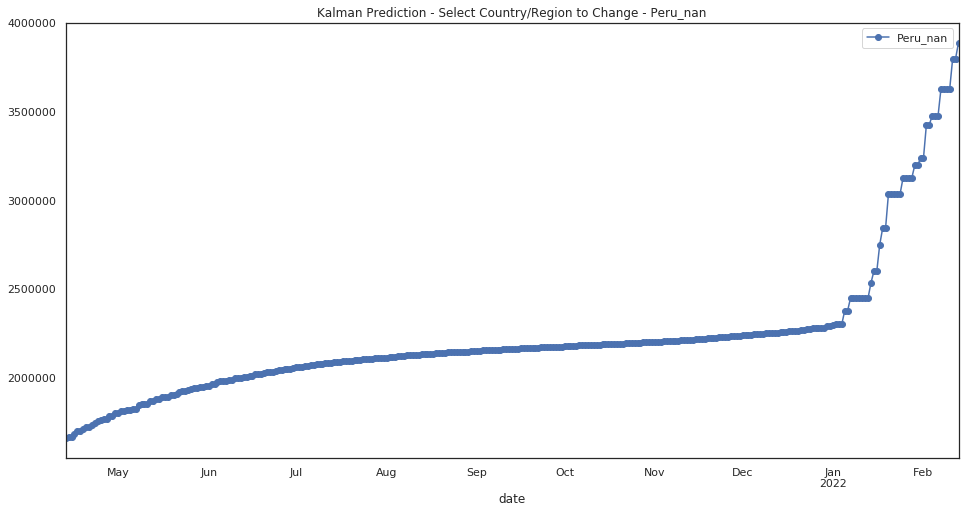

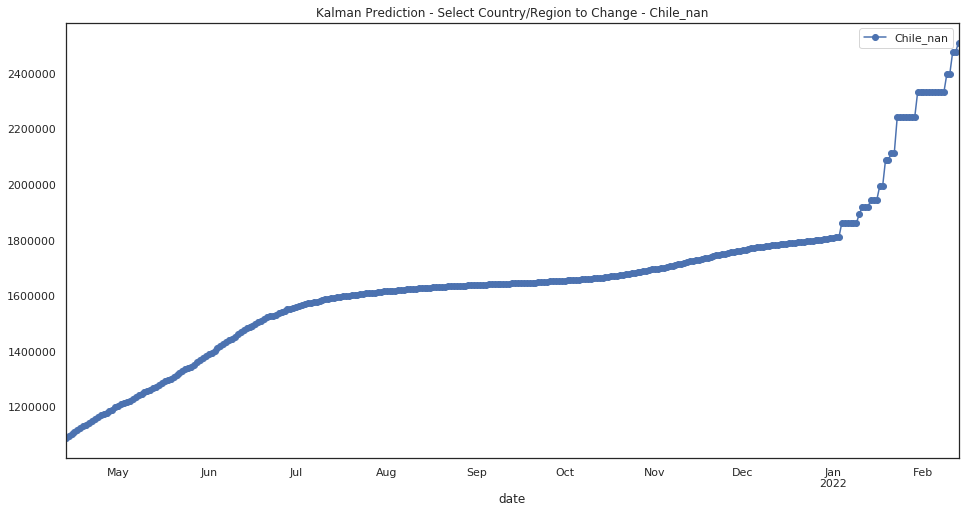

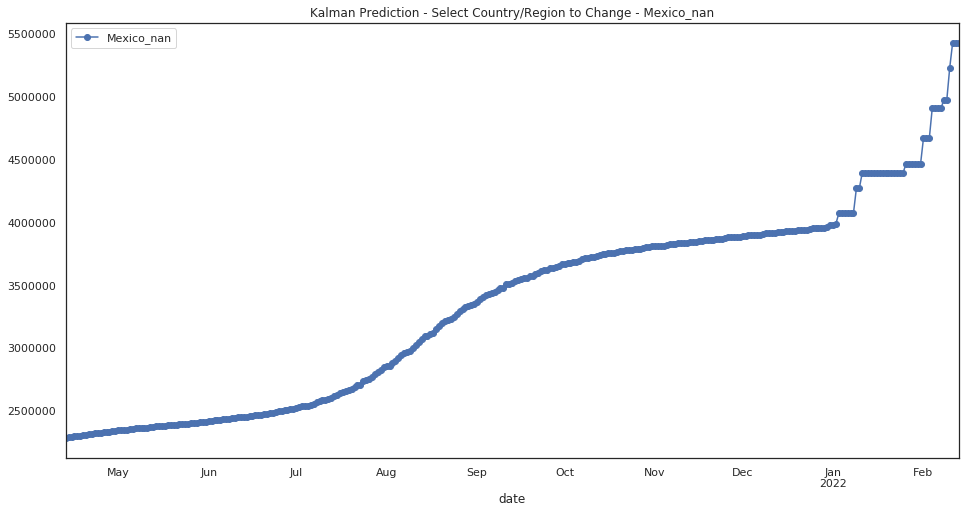

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-02-13 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      89584673.0
India_nan                                           NaN      48732615.0
Brazil_nan                                          NaN      42104578.0
United Kingdom_nan                                  NaN      24420574.0
Russia_nan                                          NaN      18361108.0
Turkey_nan                                          NaN      17155503.0
Argentina_nan                                       NaN      15006878.0
France_nan                                          NaN      14615588.0
Spain_nan                                           NaN      12060715.0
Germany_nan                                         NaN       9967677.0
Iran_nan                                            NaN       9358264.0
Italy_nan                                           NaN       8528558.0
Poland_nan                                          NaN       8012771.0
Ukraine_nan                                         NaN       7954357.0
Colombia_nan                                        NaN       7326107.0
Netherlands_nan                                     NaN       6600566.0
Indonesia_nan                                       NaN       6416192.0
Philippines_nan                                     NaN       5794732.0
South Africa_nan                                    NaN       5453367.0
Mexico_nan                                          NaN       5426222.0
Malaysia_nan                                        NaN       5104872.0
Peru_nan                                            NaN       3890032.0
Czechia_nan                                         NaN       3428502.0
Thailand_nan                                        NaN       3280559.0
Belgium_nan                                         NaN       3223954.0
Iraq_nan                                            NaN       3207668.0
Japan_nan                                           NaN       2828624.0
Vietnam_nan                                         NaN       2827037.0
Switzerland_nan                                     NaN       2578103.0
Chile_nan                                           NaN       2511385.0
...                                                 ...             ...
China_Chongqing                                     NaN          1006.0
China_Guangxi                                       NaN           984.0
France_Wallis and Futuna                            NaN           831.0
China_Unknown                                       NaN           547.0
China_Shanxi                                        NaN           470.0
China_Gansu                                         NaN           447.0
China_Hainan                                        NaN           285.0
France_Saint Pierre and Miquelon                    NaN           238.0
China_Guizhou                                       NaN           225.0
China_Ningxia                                       NaN           222.0
United Kingdom_Falkland Islands (Malvinas)          NaN           160.0
China_Macau                                         NaN           113.0
United Kingdom_Montserrat                           NaN            66.0
China_Qinghai                                       NaN            50.0
Holy See_nan                                        NaN            47.0
Solomon Islands_nan                                 NaN            38.0
Canada_Repatriated Travellers                       NaN            21.0
Canada_Grand Princess                               NaN            15.0
MS Zaandam_nan                                      NaN             9.0
Palau_nan                                           NaN             8.0
Vanuatu_nan                                         NaN             7.0
Marshall Islands_nan                                NaN             4.0
United Kingdom_Saint Helena, Ascension and Tris...  NaN             4.0
Samoa_nan                                           NaN             3.0
Kiribati_nan          

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-04-13         118723.0     180112.0     171553.0      80241.0   
2021-04-14         118833.0     180290.0     171705.0      80264.0   
2021-04-15          57492.0     128959.0     118975.0      12641.0   
2021-04-16          57534.0     129128.0     119142.0      12641.0   
2021-04-17          57612.0     129307.0     119323.0      12712.0   
2021-04-18          57721.0     129456.0     119486.0      12771.0   
2021-04-19          57793.0     129594.0     119642.0      12805.0   
2021-04-20          57898.0     129694.0     119805.0      12805.0   
2021-04-21          58912.0     130532.0     120905.0      12874.0   
2021-04-22          59005.0     130670.0     121096.0      12917.0   
2021-04-23          59268.0     130828.0     121294.0      13028.0   
2021-04-24          59376.0     130972.0     121471.0      13007.0   
2021-04-25          59527.0     131102.0     121655.0      13109.0   
2021-04-26          59741.0     131179.0     121842.0      13060.0   
2021-04-27          59897.0     131293.0     122066.0      13130.0   
2021-04-28          60025.0     131418.0     122303.0      13121.0   
2021-04-29          60272.0     131537.0     122583.0      13181.0   
2021-04-30          60405.0     131652.0     122833.0      13198.0   
2021-05-01          60618.0     131753.0     123041.0      13232.0   
2021-05-02          60792.0     131813.0     123247.0      13392.0   
2021-05-03          60973.0     131851.0     123436.0      13282.0   
2021-05-04          61228.0     131895.0     123701.0      13357.0   
2021-05-05          61418.0     131982.0     123978.0      13344.0   
2021-05-06          61786.0     132080.0     124193.0      13344.0   
2021-05-07          62022.0     132156.0     124416.0      13375.0   
2021-05-08          62366.0     132246.0     124621.0      13390.0   
2021-05-09          62483.0     132308.0     124820.0      13442.0   
2021-05-10          62788.0     132338.0     125007.0      13439.0   
2021-05-11          63020.0     132381.0     125199.0      13503.0   
2021-05-12          63268.0     132421.0     125401.0      13466.0   
...                     ...          ...          ...          ...   
2022-01-16         181749.0     238836.0     248740.0      30096.0   
2022-01-17         182267.0     241650.0     248272.0      30648.0   
2022-01-18         182256.0     239504.0     248762.0      31816.0   
2022-01-19         182256.0     239504.0     254044.0      31816.0   
2022-01-20         187277.0     239504.0     256748.0      31816.0   
2022-01-21         189731.0     250082.0     264413.0      31816.0   
2022-01-22         191402.0     255368.0     269108.0      31816.0   
2022-01-23         198025.0     252028.0     265580.0      32365.0   
2022-01-24         199330.0     252559.0     270445.0      33618.0   
2022-01-25         197986.0     262319.0     272140.0      34018.0   
2022-01-26         197740.0     275288.0     270824.0      35045.0   
2022-01-27         208530.0     275616.0     274136.0      36080.0   
2022-01-28         213708.0     273283.0     275417.0      36460.0   
2022-01-29         211018.0     282125.0     279865.0      37587.0   
2022-01-30         217943.0     286367.0     287906.0      37587.0   
2022-01-31         226354.0     284080.0     289069.0      38391.0   
2022-02-01         227350.0     284080.0     290142.0      40603.0   
2022-02-02         225642.0     284080.0     298995.0      40603.0   
2022-02-03         225570.0     299079.0     301971.0      40917.0   
2022-02-04         237911.0     307459.0     299214.0      42699.0   
2022-02-05         252929.0     302027.0     304267.0      44362.0   
2022-02-06         260679.0     302477.0     308768.0      45029.0   
2022-02-07         261885.0     302027.0     308204.0      46740.0   
2022-02-08         264918.0     317966.0     307578.0      46740.0   
2022-02-09

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'United Kingdom_nan',
 'Russia_nan',
 'Turkey_nan',
 'Argentina_nan',
 'France_nan',
 'Spain_nan',
 'Germany_nan',
 'Iran_nan',
 'Italy_nan',
 'Poland_nan',
 'Ukraine_nan',
 'Colombia_nan',
 'Netherlands_nan',
 'Indonesia_nan',
 'Philippines_nan',
 'South Africa_nan',
 'Mexico_nan',
 'Malaysia_nan',
 'Peru_nan',
 'Czechia_nan',
 'Thailand_nan',
 'Belgium_nan',
 'Iraq_nan',
 'Japan_nan',
 'Vietnam_nan',
 'Switzerland_nan',
 'Chile_nan',
 'Bangladesh_nan',
 'Slovakia_nan',
 'Serbia_nan',
 'Portugal_nan',
 'Greece_nan',
 'Romania_nan',
 'Israel_nan',
 'Austria_nan',
 'Sweden_nan',
 'Hungary_nan',
 'Pakistan_nan',
 'Kazakhstan_nan',
 'Denmark_nan',
 'Jordan_nan',
 'Morocco_nan',
 'Georgia_nan',
 'Ireland_nan',
 'Nepal_nan',
 'Canada_Quebec',
 'Korea, South_nan',
 'Bulgaria_nan',
 'Paraguay_nan',
 'United Arab Emirates_nan',
 'Belarus_nan',
 'Cuba_nan',
 'Tunisia_nan',
 'Azerbaijan_nan',
 'Lebanon_nan',
 'Sri Lanka_nan',
 'West Bank and Ga

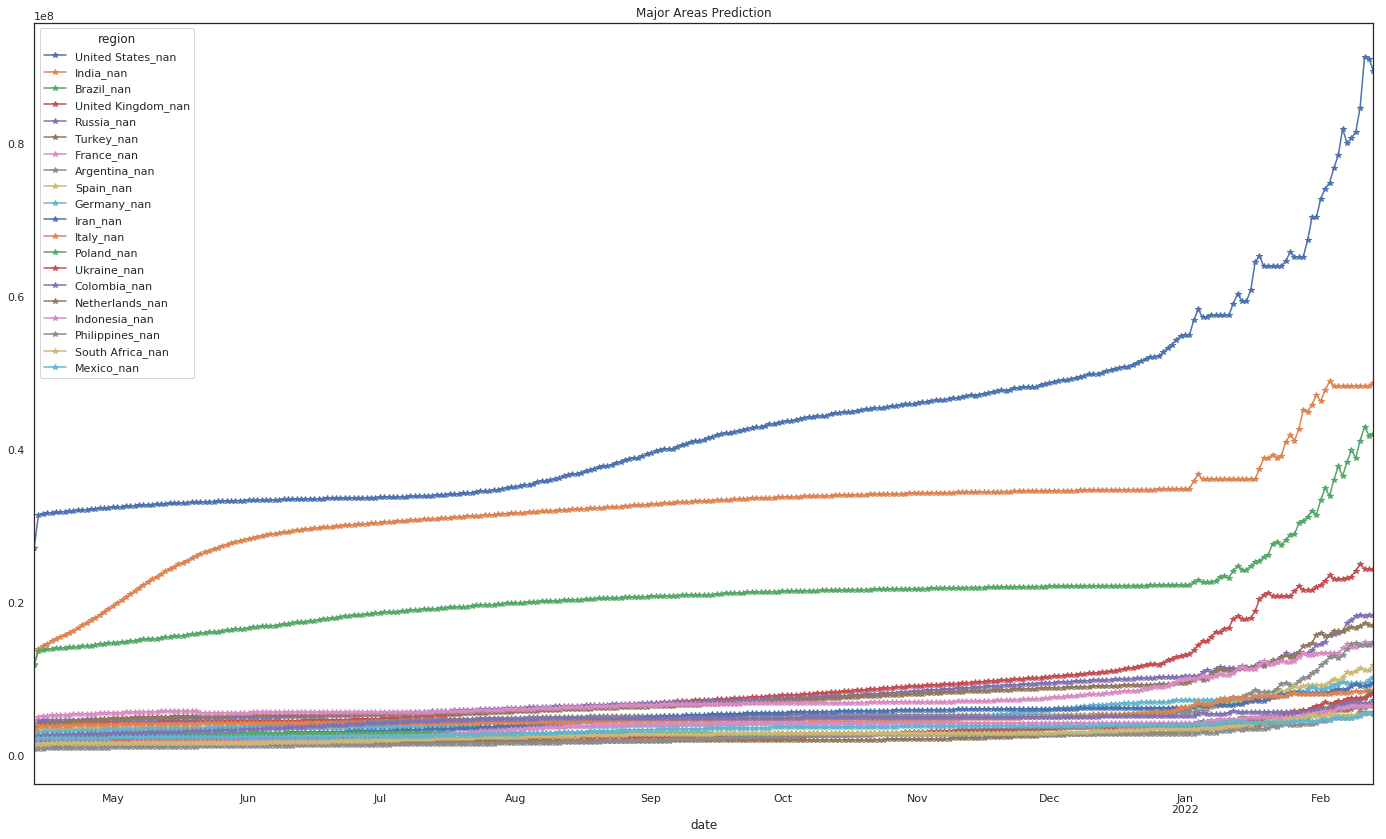

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

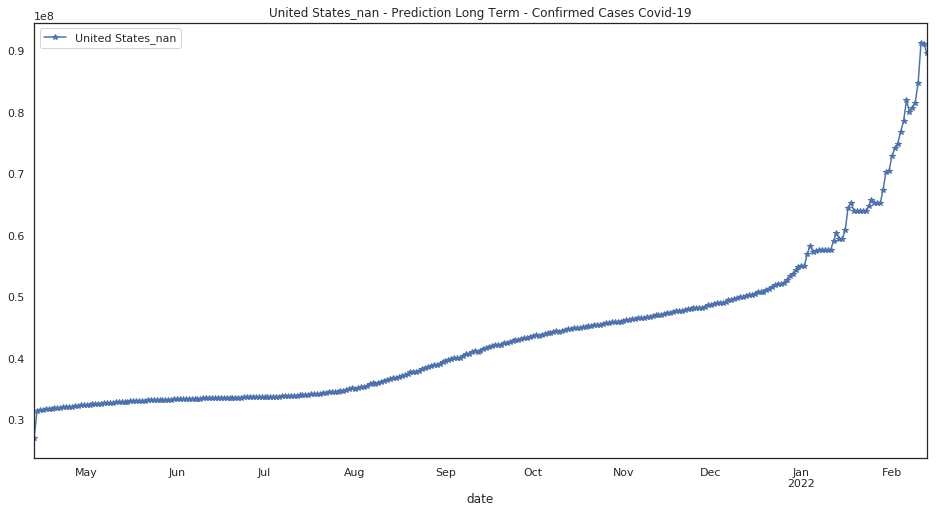

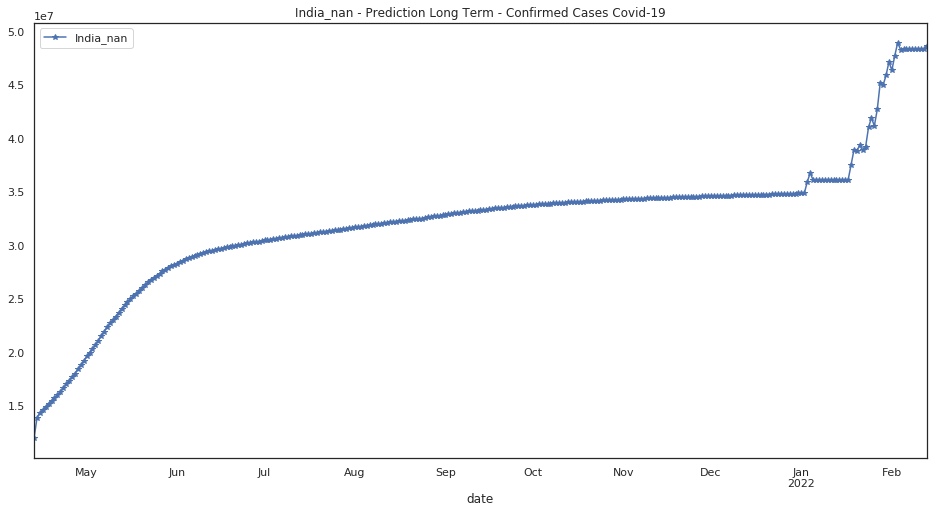

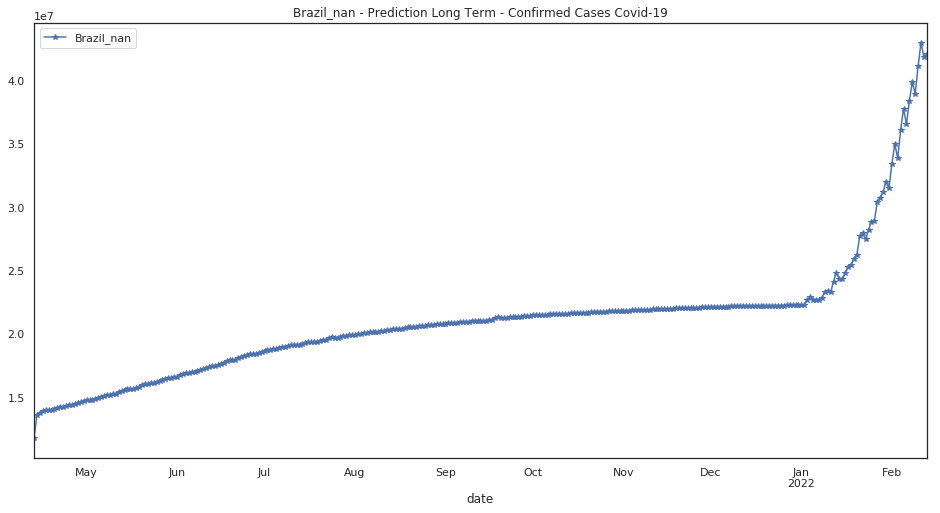

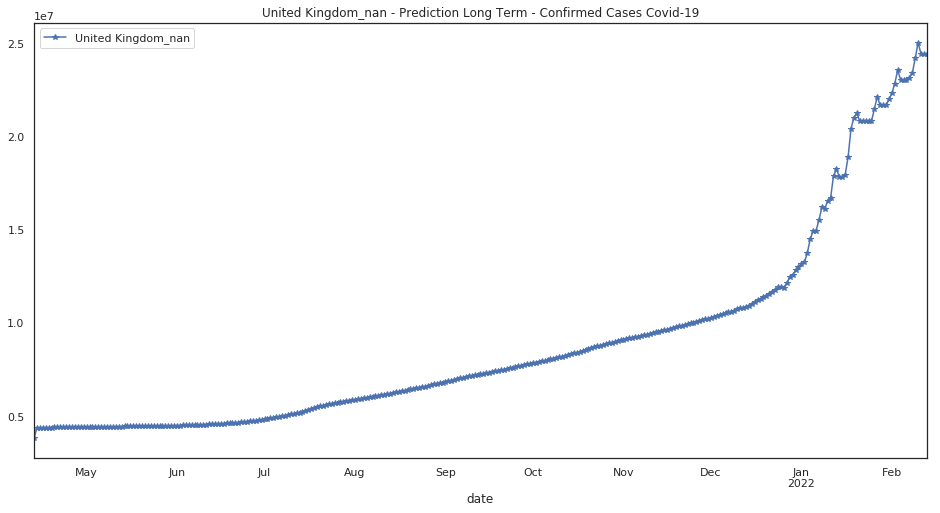

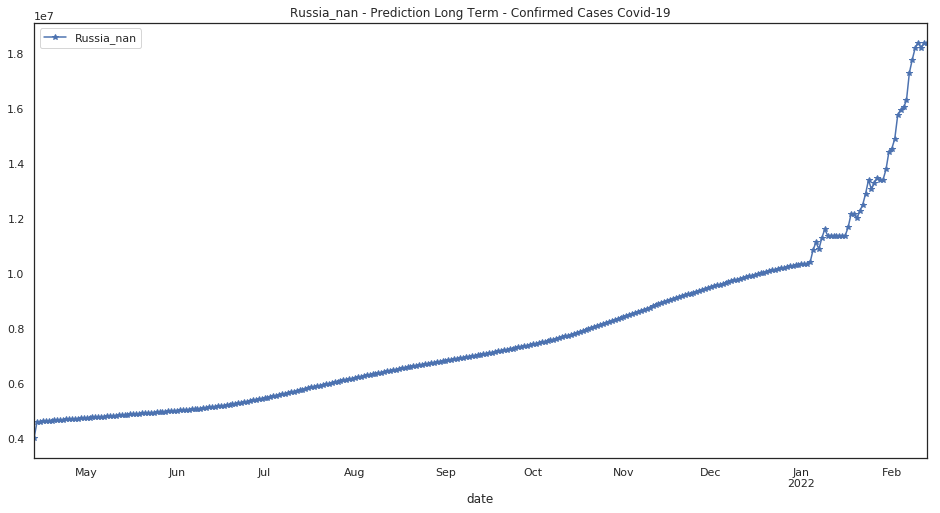

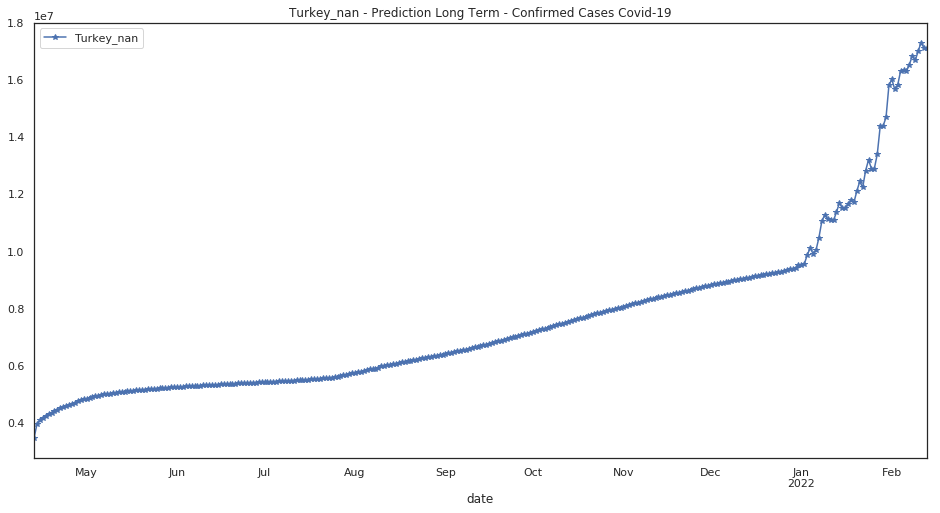

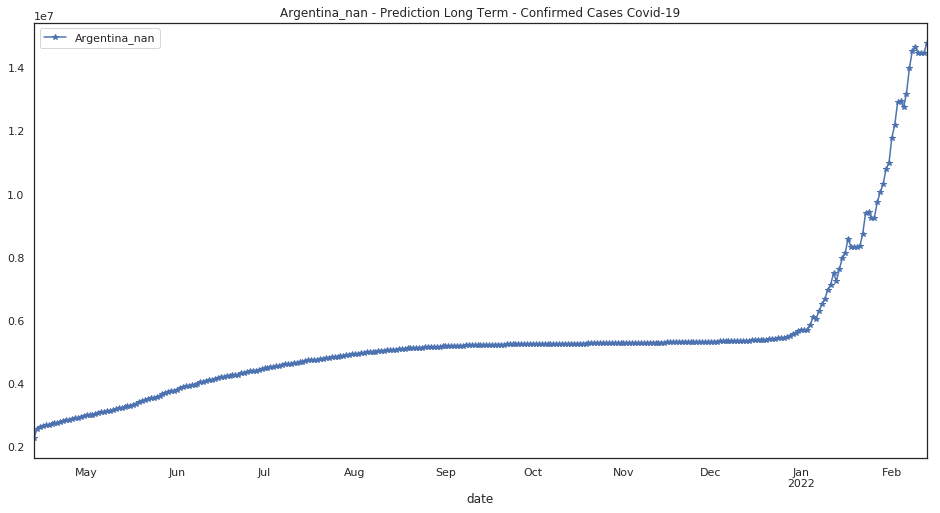

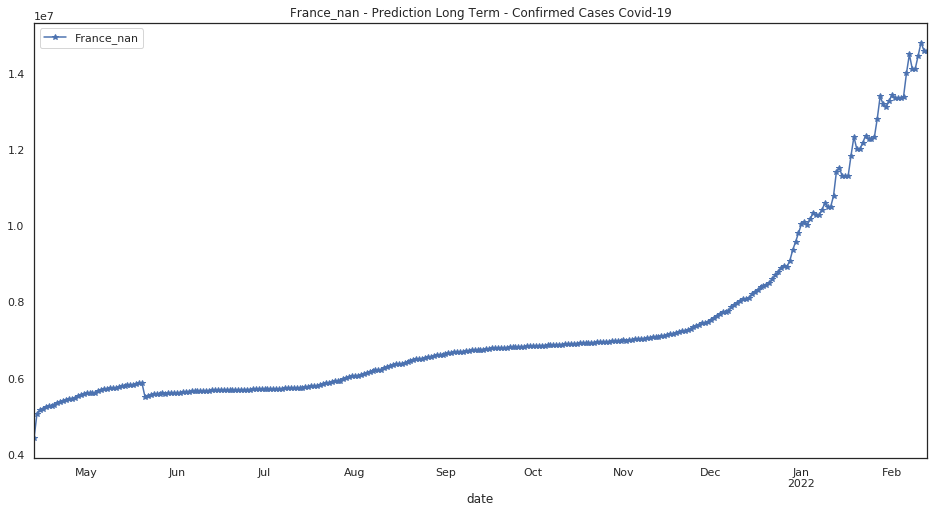

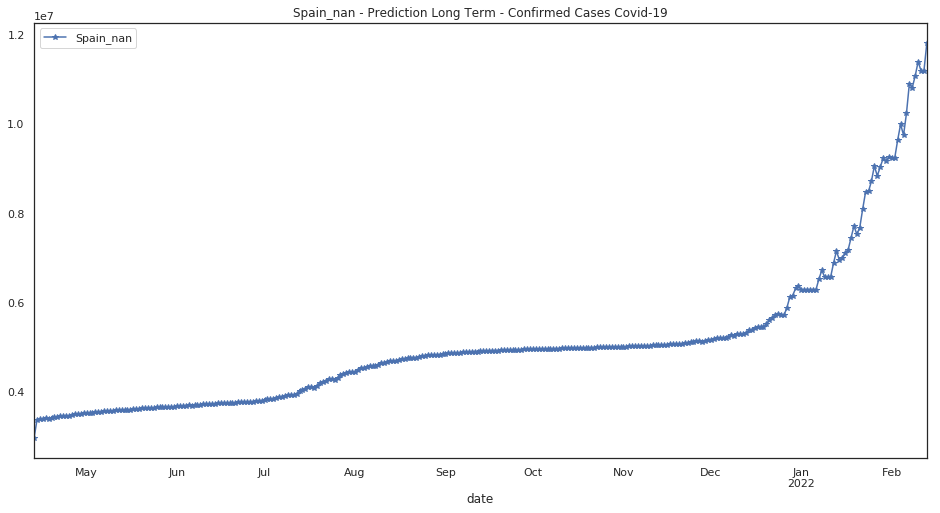

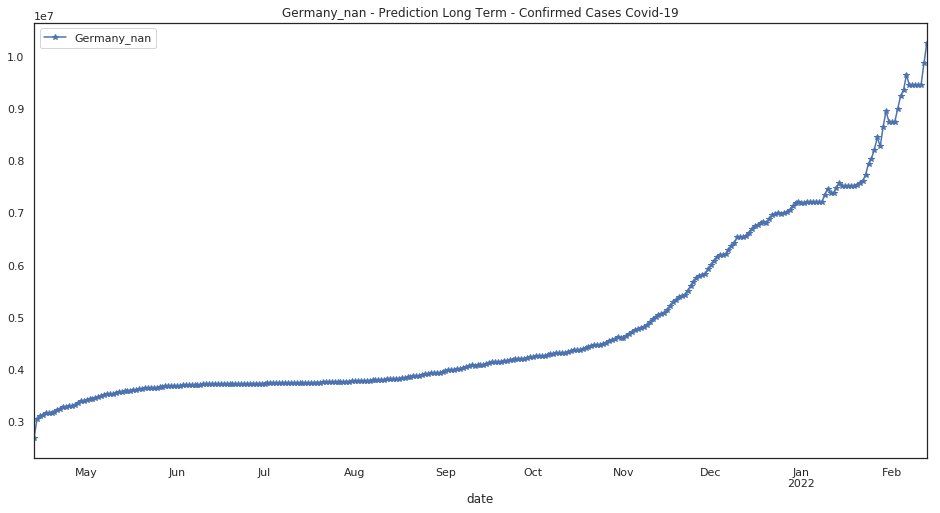

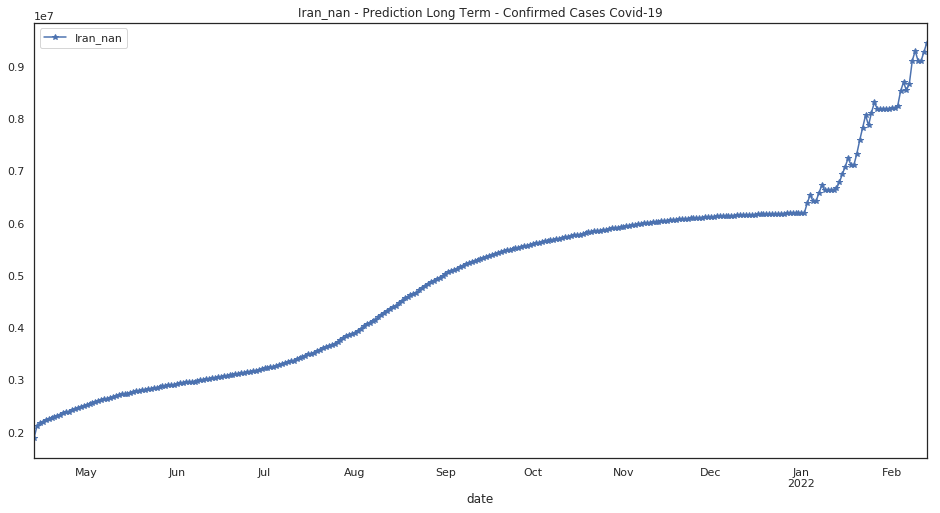

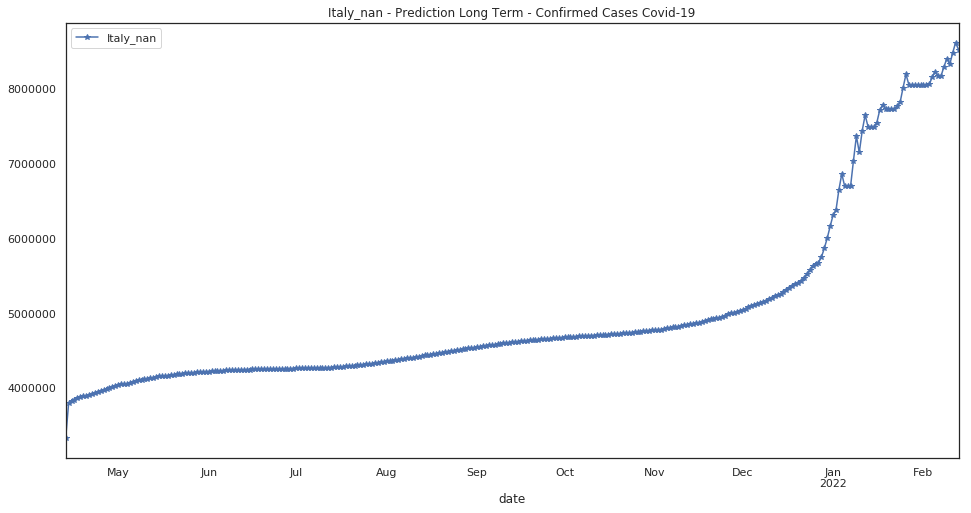

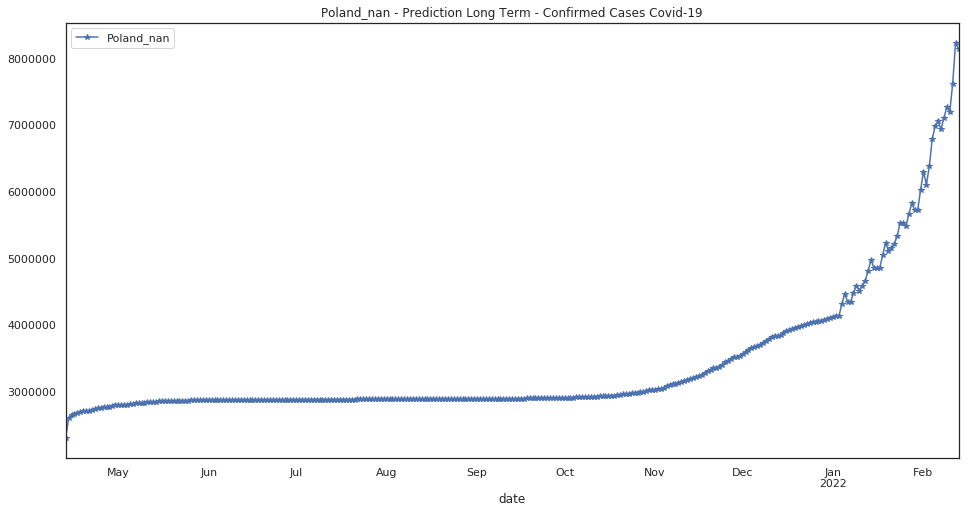

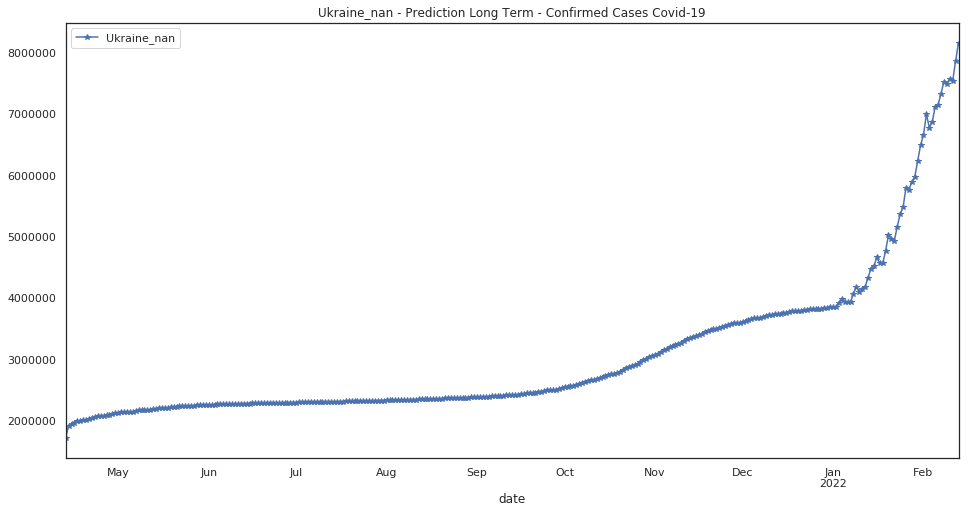

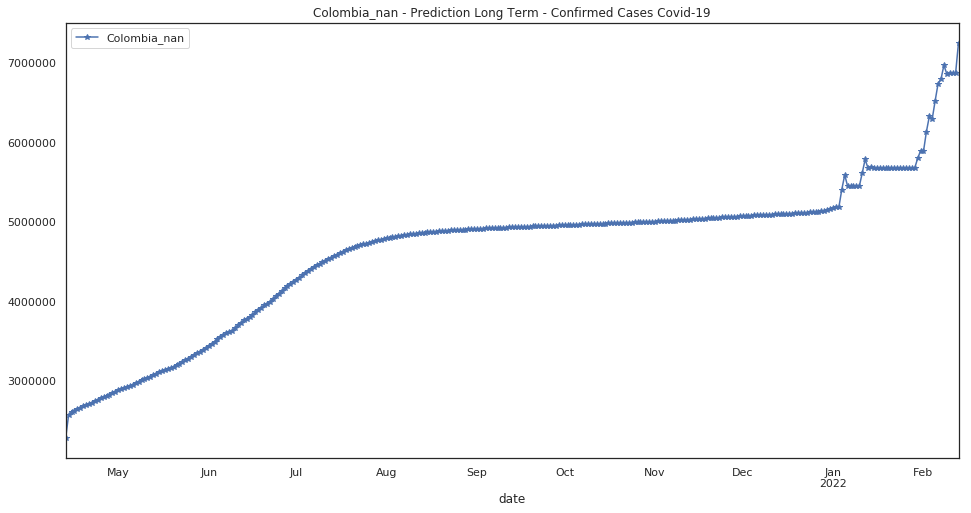

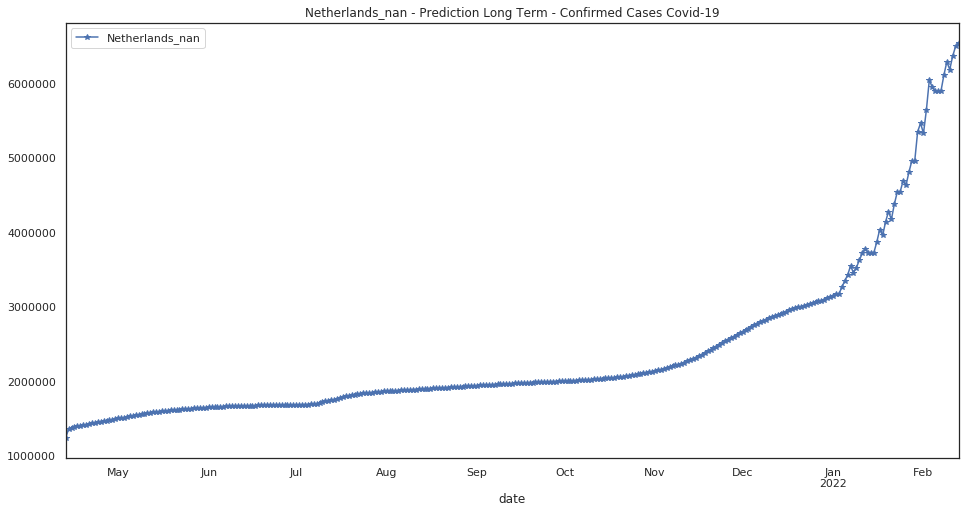

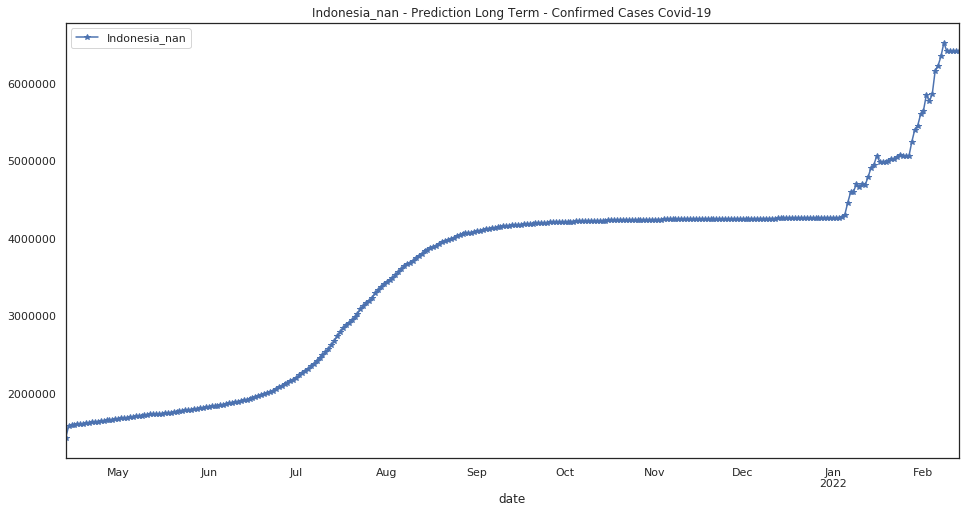

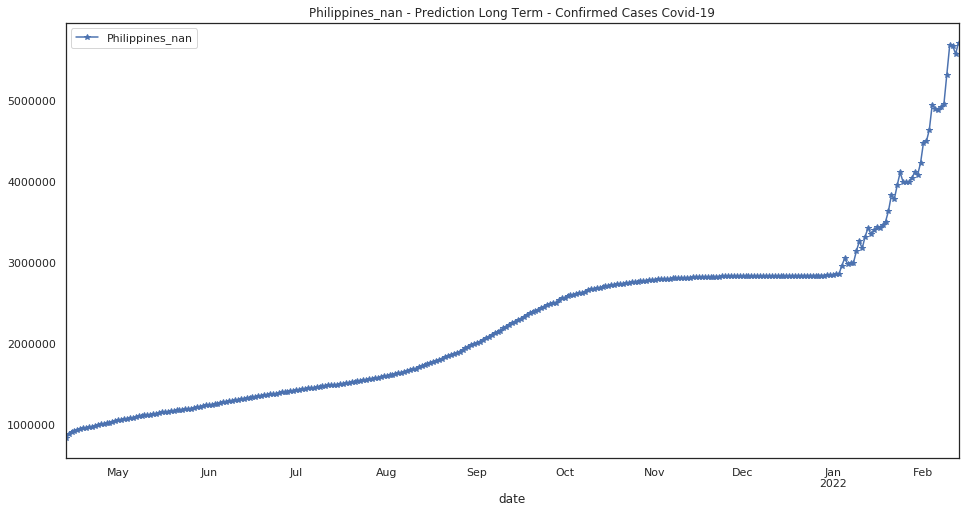

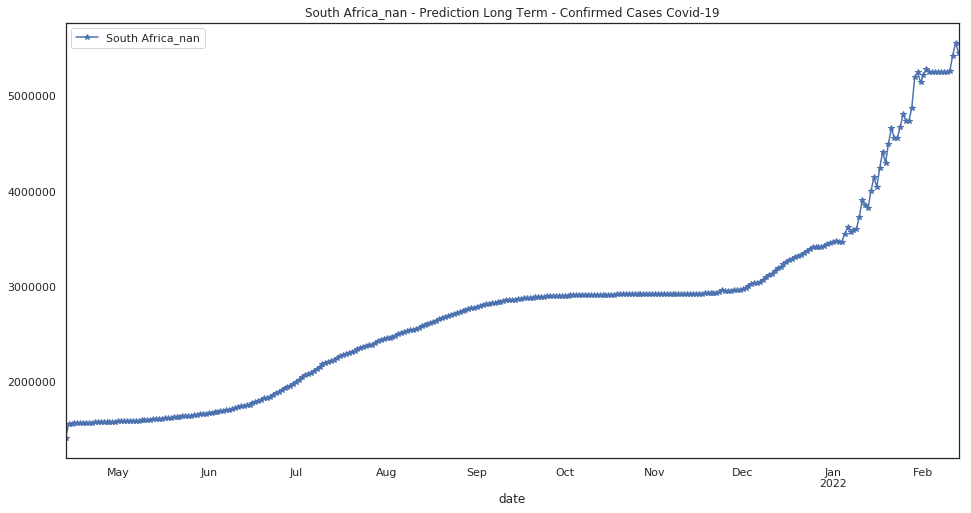

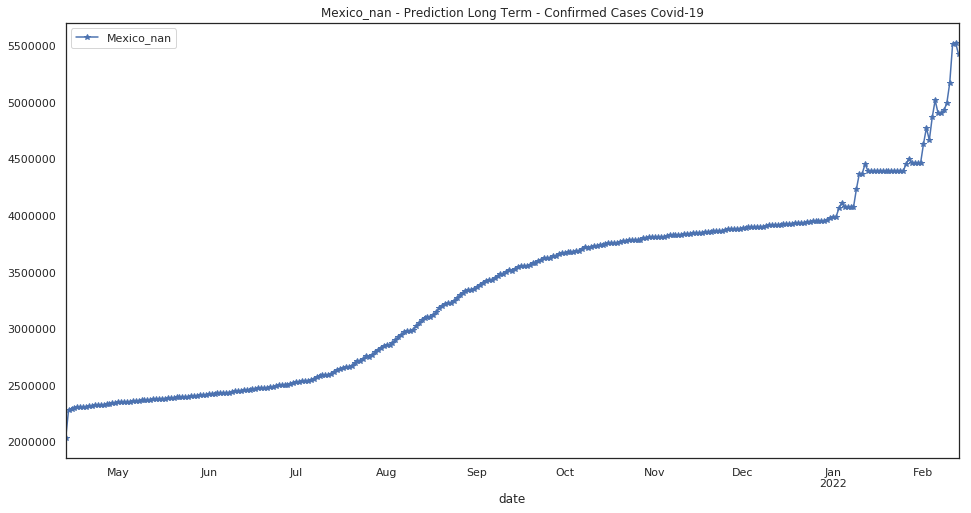

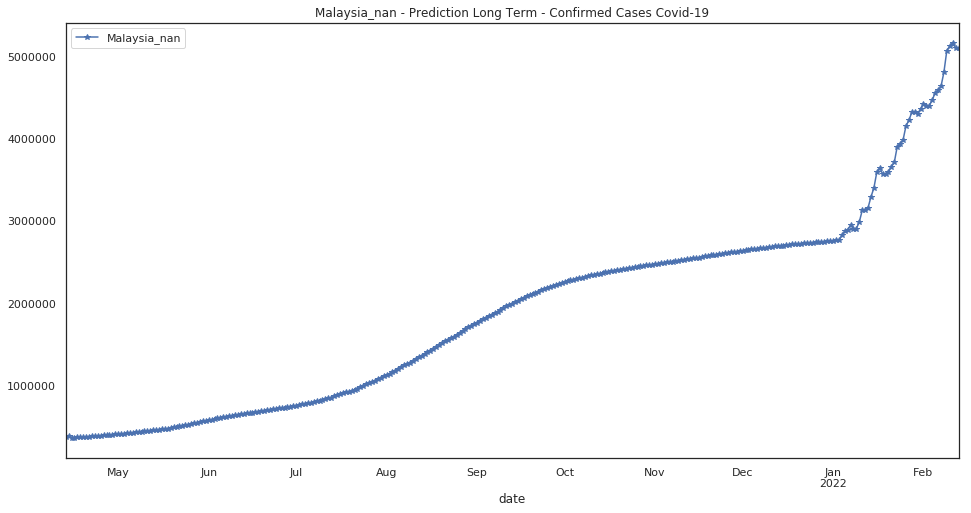

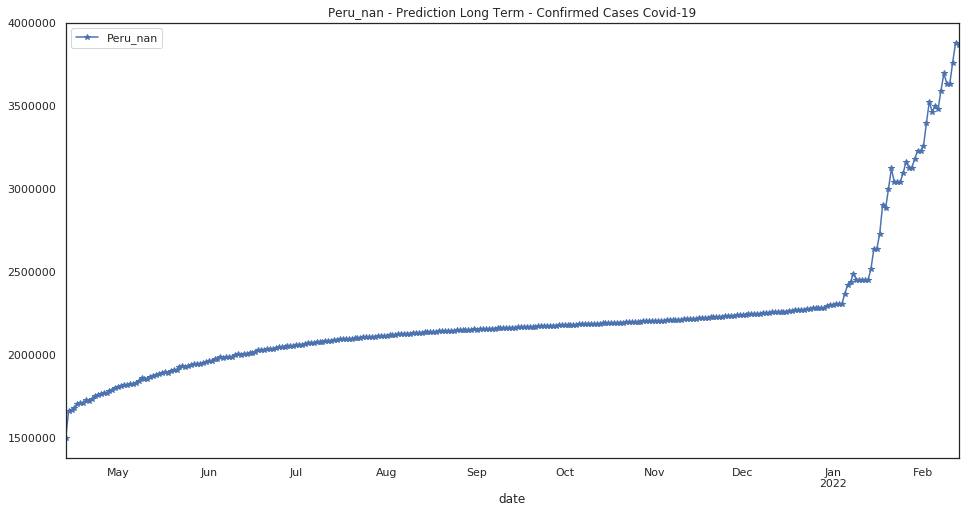

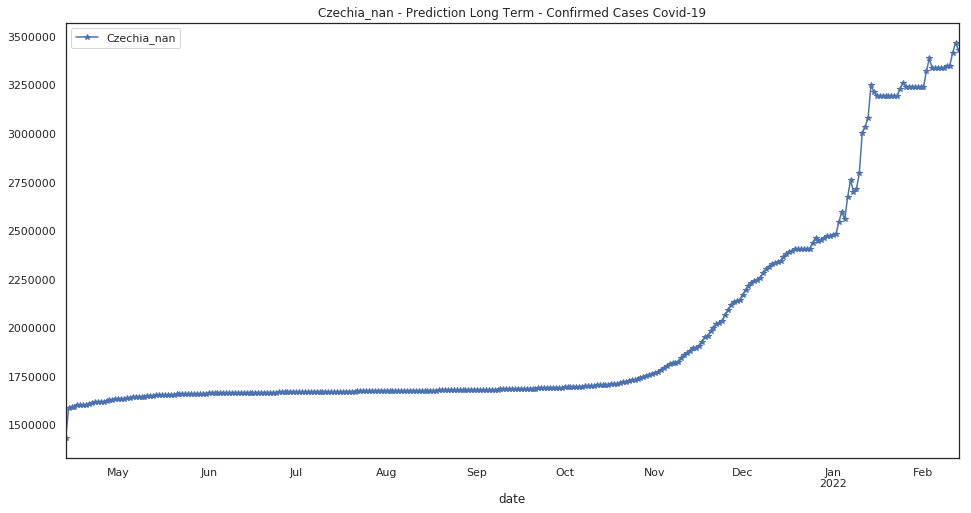

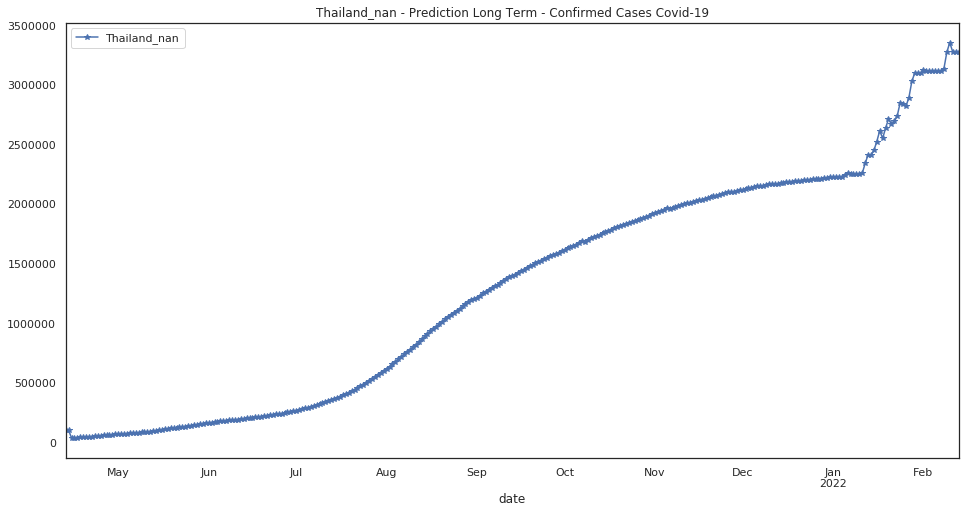

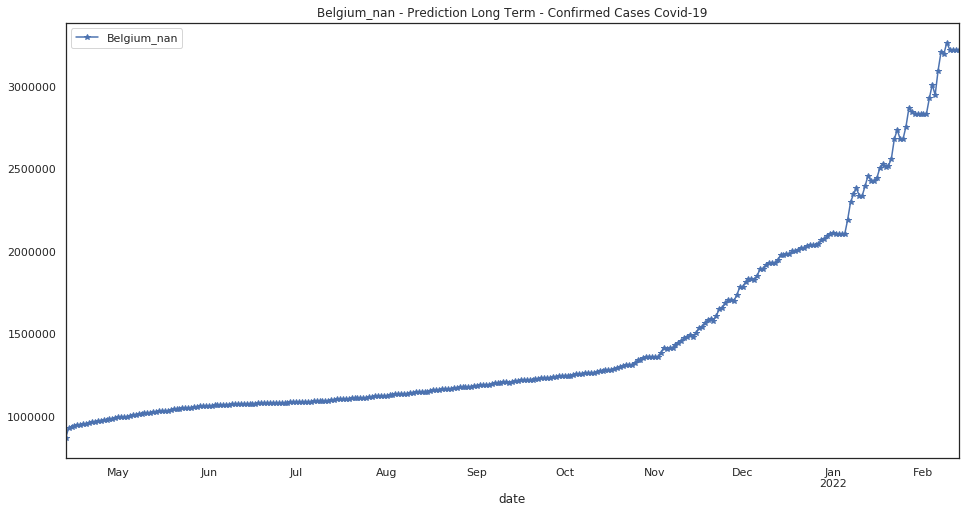

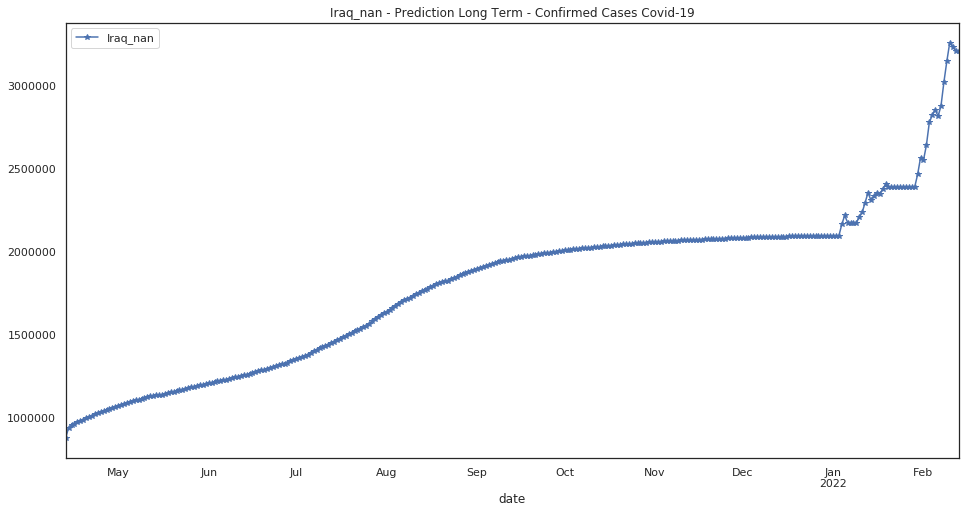

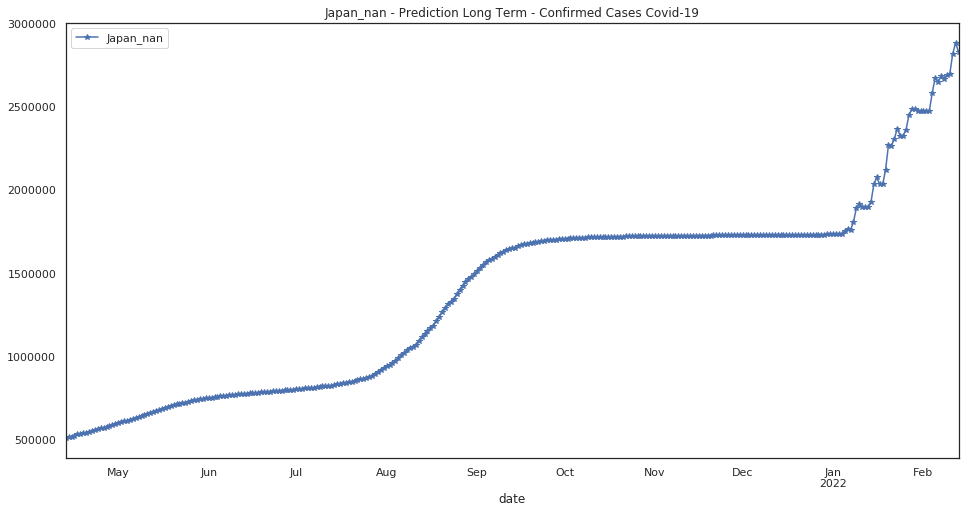

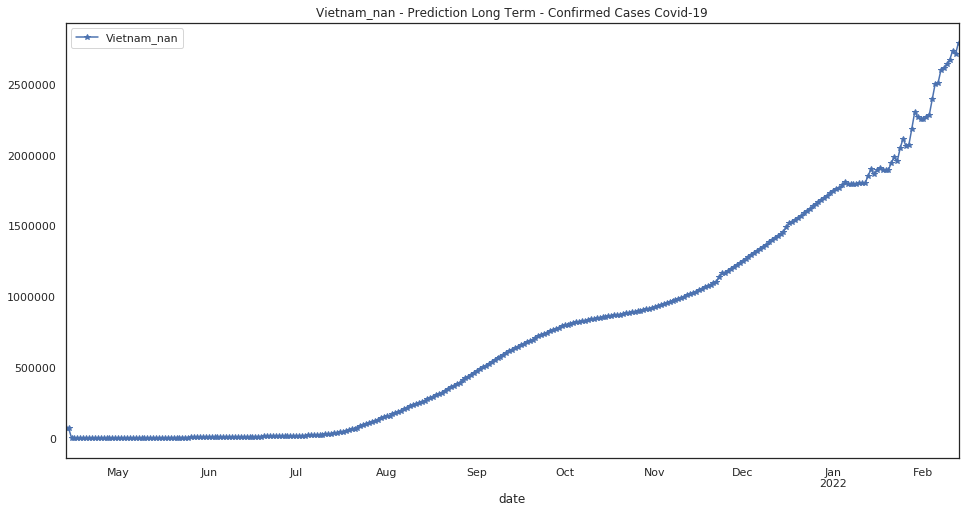

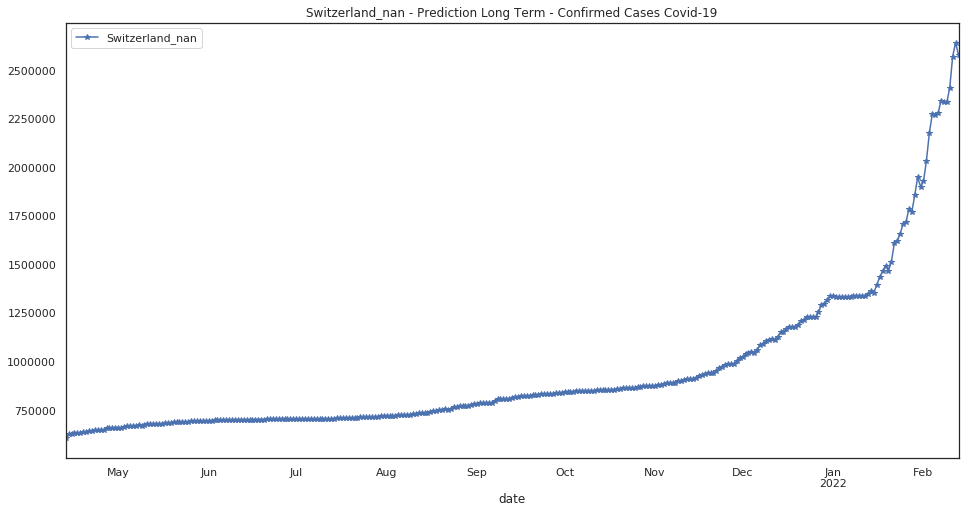

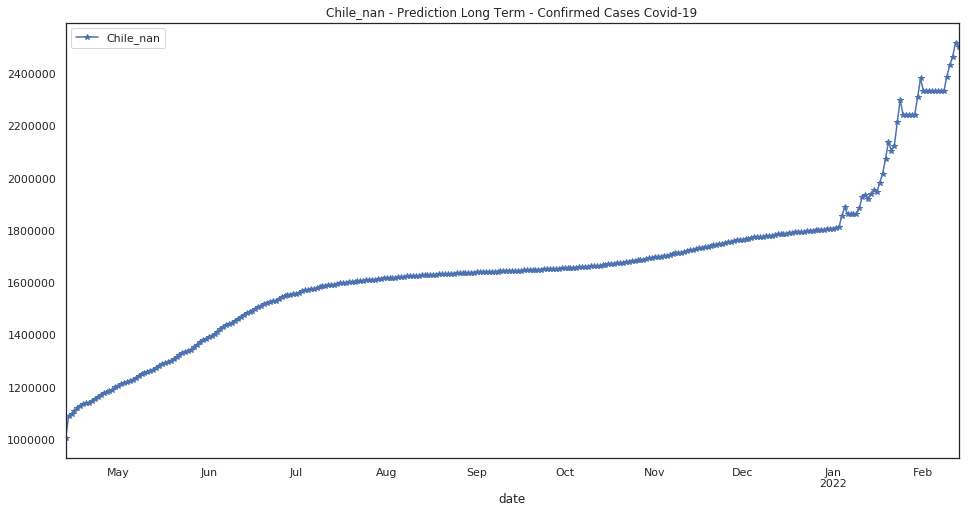

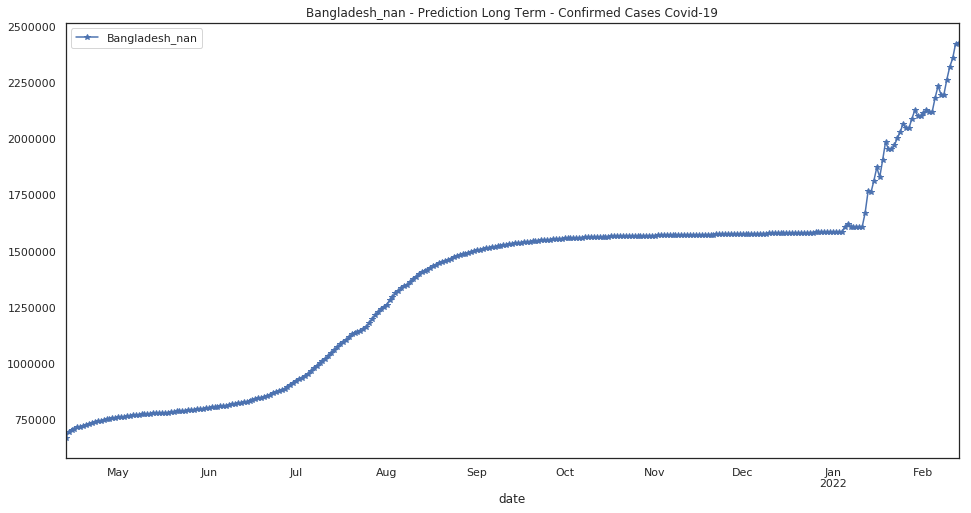

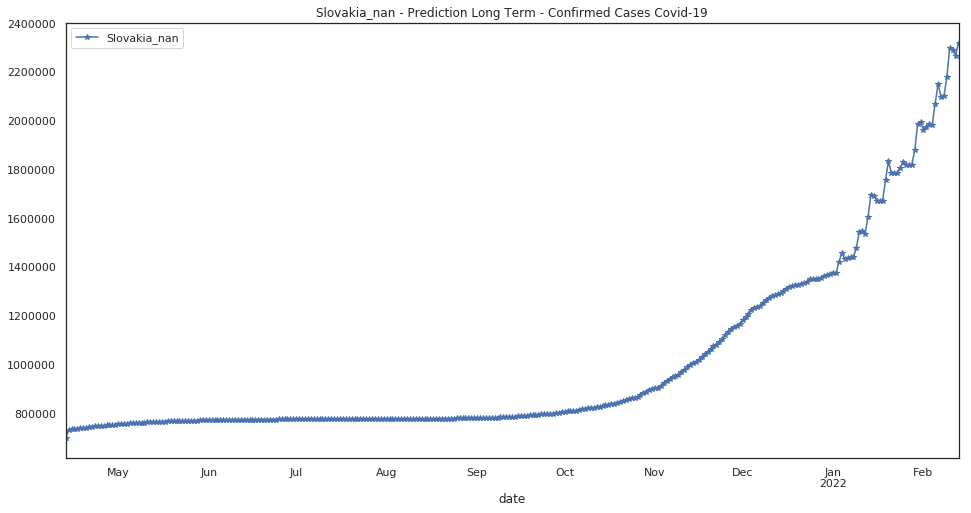

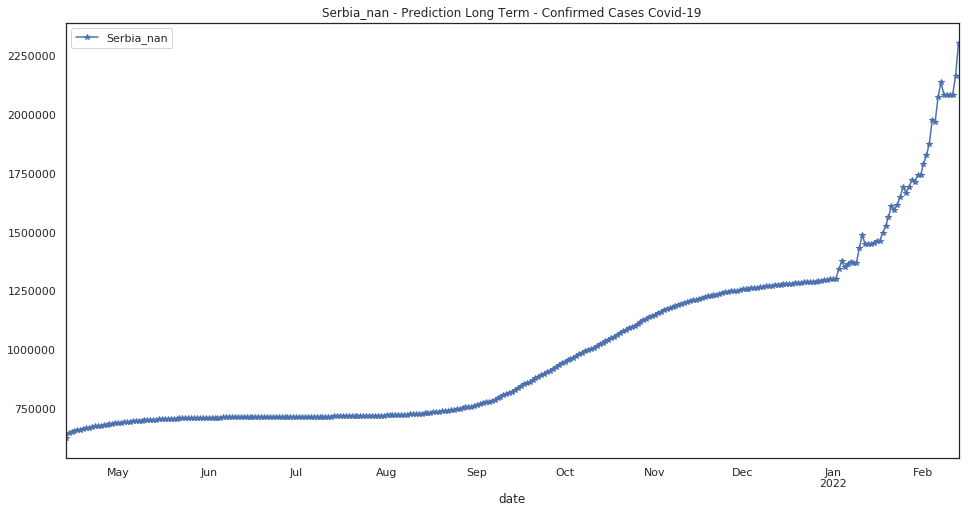

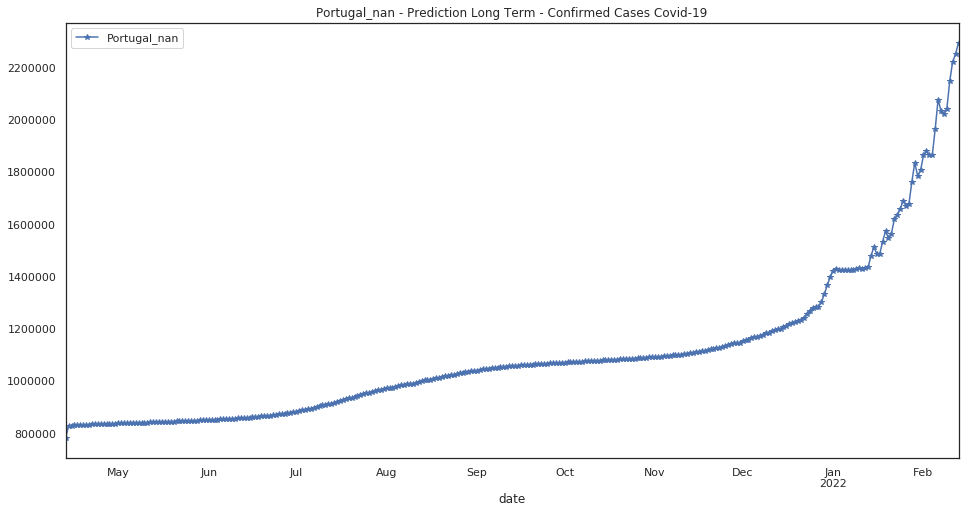

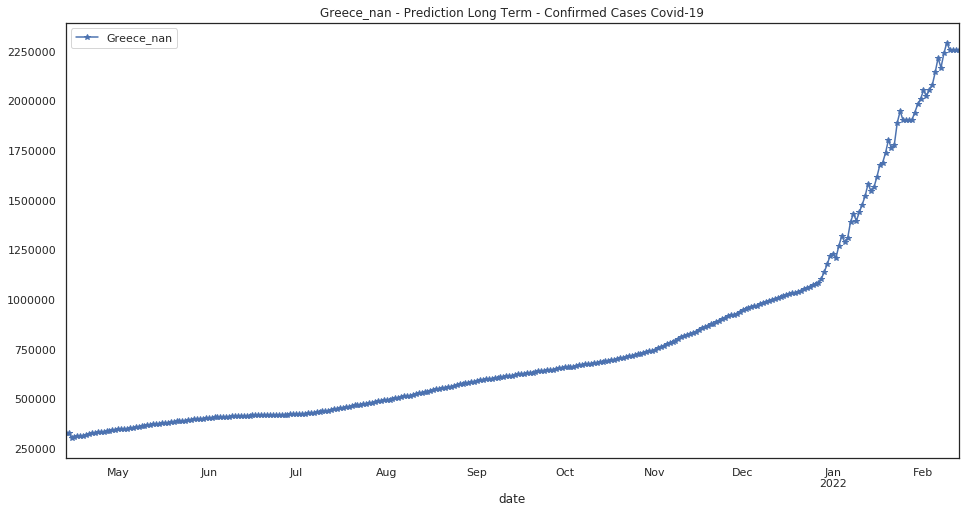

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

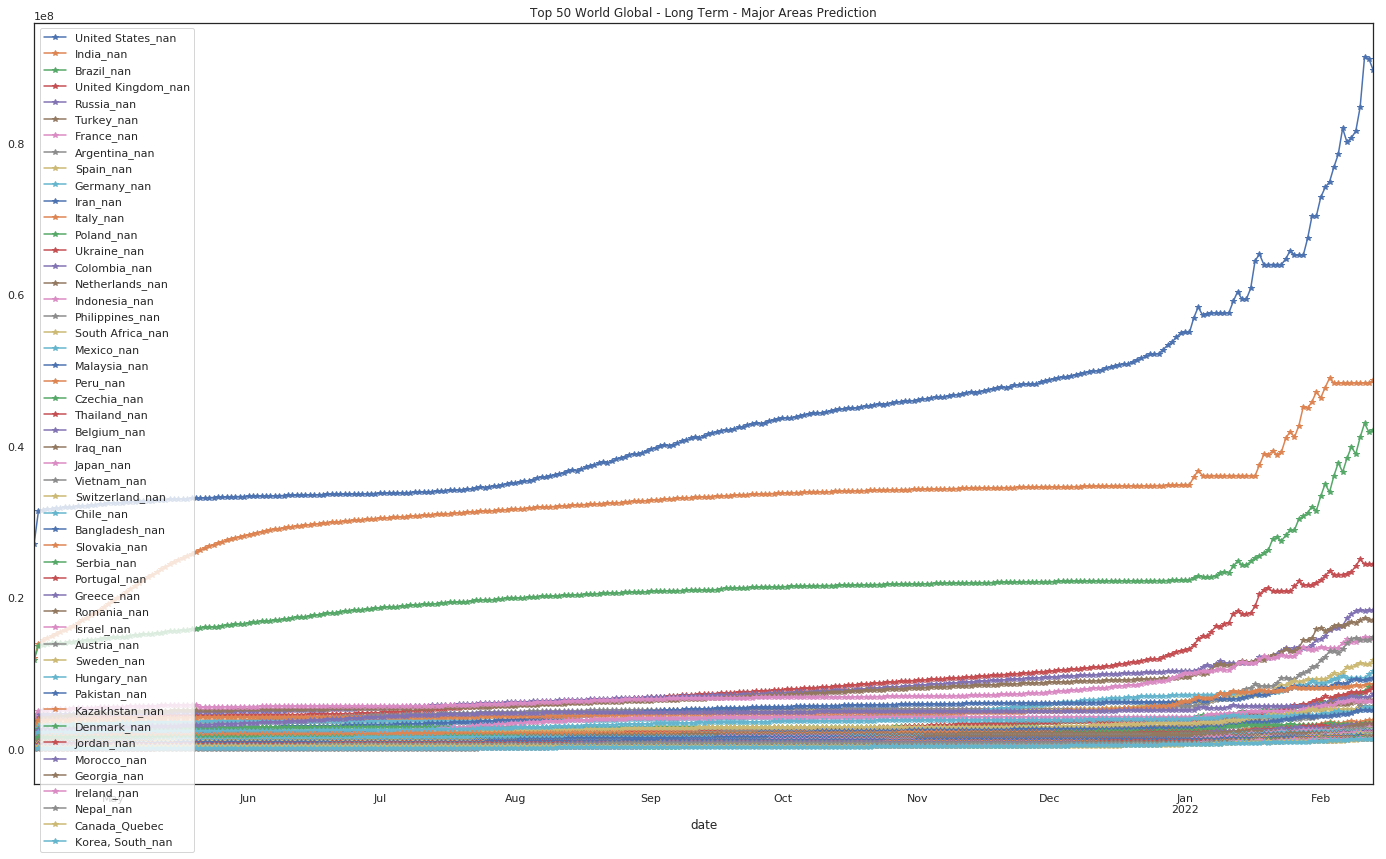

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

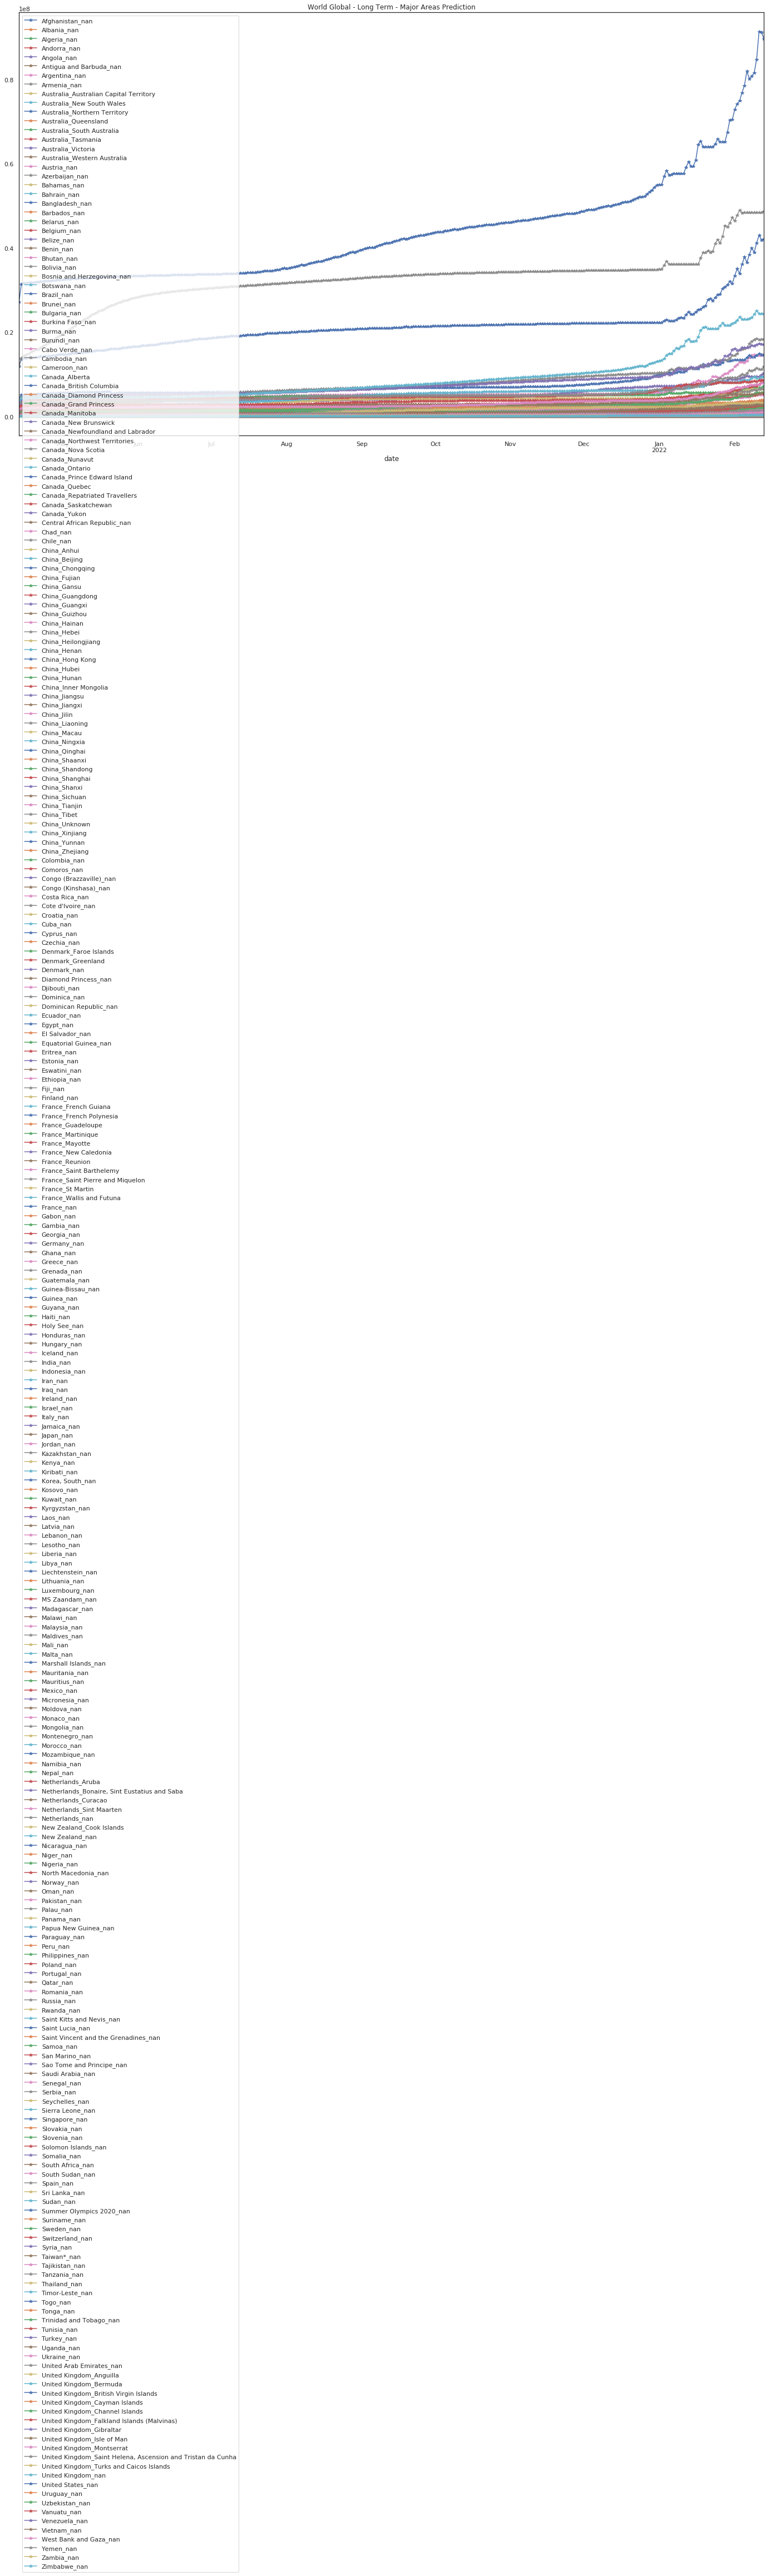

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-05-28          69568.0     132876.0     128912.0      13731.0   
2021-05-29          70456.0     132890.0     129174.0      13709.0   
2021-05-30          71043.0     132903.0     129437.0      13760.0   
2021-05-31          72211.0     132910.0     129631.0      13786.0   
2021-06-01          73158.0     132928.0     129915.0      13727.0   
2021-06-02          74198.0     132944.0     130323.0      13797.0   
2021-06-03          75371.0     132954.0     130678.0      13748.0   
2021-06-04          76793.0     132966.0     131066.0      13780.0   
2021-06-05          78001.0     132969.0     131396.0      13790.0   
2021-06-06          79374.0     132973.0     131665.0      13815.0   
2021-06-07          80973.0     132978.0     131977.0      13829.0   
2021-06-08          82349.0     132990.0     132322.0      13777.0   
2021-06-09          84104.0     133009.0     132708.0      13828.0   
2021-06-10          85886.0     133022.0     133051.0      13815.0   
2021-06-11          87686.0     133033.0     133415.0      13805.0   
2021-06-12          88870.0     133045.0     133765.0      13833.0   
2021-06-13          90152.0     133054.0     134081.0      13868.0   
2021-06-14          91594.0     133057.0     134426.0      13876.0   
2021-06-15          93245.0     133063.0     134794.0      13826.0   
2021-06-16          93543.0     133070.0     135144.0      13877.0   
2021-06-17          96711.0     133076.0     135525.0      13854.0   
2021-06-18          98469.0     133080.0     135905.0      13877.0   
2021-06-19         100597.0     133083.0     136274.0      13878.0   
2021-06-20         102274.0     133086.0     136528.0      13890.0   
2021-06-21         104060.0     133086.0     136955.0      13908.0   
2021-06-22         105804.0     133091.0     137362.0      13864.0   
2021-06-23         108003.0     133094.0     137732.0      13923.0   
2021-06-24         109601.0     133096.0     138099.0      13887.0   
2021-06-25         111729.0     133102.0     138456.0      13911.0   
2021-06-26         113326.0     133106.0     138801.0      13908.0   
...                     ...          ...          ...          ...   
2022-01-15         181426.0     231411.0     247758.0      30096.0   
2022-01-16         181749.0     238836.0     248740.0      30096.0   
2022-01-17         182267.0     241650.0     248272.0      30648.0   
2022-01-18         182256.0     239504.0     248762.0      31816.0   
2022-01-19         182256.0     239504.0     254044.0      31816.0   
2022-01-20         187277.0     239504.0     256748.0      31816.0   
2022-01-21         189731.0     250082.0     264413.0      31816.0   
2022-01-22         191402.0     255368.0     269108.0      31816.0   
2022-01-23         198025.0     252028.0     265580.0      32365.0   
2022-01-24         199330.0     252559.0     270445.0      33618.0   
2022-01-25         197986.0     262319.0     272140.0      34018.0   
2022-01-26         197740.0     275288.0     270824.0      35045.0   
2022-01-27         208530.0     275616.0     274136.0      36080.0   
2022-01-28         213708.0     273283.0     275417.0      36460.0   
2022-01-29         211018.0     282125.0     279865.0      37587.0   
2022-01-30         217943.0     286367.0     287906.0      37587.0   
2022-01-31         226354.0     284080.0     289069.0      38391.0   
2022-02-01         227350.0     284080.0     290142.0      40603.0   
2022-02-02         225642.0     284080.0     298995.0      40603.0   
2022-02-03         225570.0     299079.0     301971.0      40917.0   
2022-02-04         237911.0     307459.0     299214.0      42699.0   
2022-02-05         252929.0     302027.0     304267.0      44362.0   
2022-02-06         260679.0     302477.0     308768.0      45029.0   
2022-02-07         261885.0     302027.0     308204.0      46740.0   
2022-02-08

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                              Antigua and Barbuda_nan  17.060800  -61.796400   
6                                        Argentina_nan -38.416100  -63.616700   
7                                          Armenia_nan  40.069100   45.038200   
8               Australia_Australian Capital Territory -35.473500  149.012400   
9                            Australia_New South Wales -33.868800  151.209300   
10                        Australia_Northern Territory -12.463400  130.845600   
11                                Australia_Queensland -27.469800  153.025100   
12                           Australia_South Australia -34.928500  138.600700   
13                                  Australia_Tasmania -42.882100  147.327200   
14                                  Australia_Victoria -37.813600  144.963100   
15                         Australia_Western Australia -31.950500  115.860500   
16                                         Austria_nan  47.516200   14.550100   
17                                      Azerbaijan_nan  40.143100   47.576900   
18                                         Bahamas_nan  25.025885  -78.035889   
19                                         Bahrain_nan  26.027500   50.550000   
20                                      Bangladesh_nan  23.685000   90.356300   
21                                        Barbados_nan  13.193900  -59.543200   
22                                         Belarus_nan  53.709800   27.953400   
23                                         Belgium_nan  50.833300    4.469936   
24                                          Belize_nan  17.189900  -88.497600   
25                                           Benin_nan   9.307700    2.315800   
26                                          Bhutan_nan  27.514200   90.433600   
27                                         Bolivia_nan -16.290200  -63.588700   
28                          Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                        Botswana_nan -22.328500   24.684900   
..                                                 ...        ...         ...   
256                                           Togo_nan   8.619500    0.824800   
257                                          Tonga_nan -21.179000 -175.198200   
258                            Trinidad and Tobago_nan  10.691800  -61.222500   
259                                        Tunisia_nan  33.886917    9.537499   
260                                         Turkey_nan  38.963700   35.243300   
261                                  United States_nan  40.000000 -100.000000   
262                                         Uganda_nan   1.373333   32.290275   
263                                        Ukraine_nan  48.379400   31.165600   
264                           United Arab Emirates_nan  23.424076   53.847818   
265                            United Kingdom_Anguilla  18.220600  -63.068600   
266                             United Kingdom_Bermuda  32.307800  -64.750500   
267              United Kingdom_British Virgin Islands  18.420700  -64.640000   
268                      United Kingdom_Cayman Islands  19.313300  -81.254600   
269                     United Kingdom_Channel Islands  49.372300   -2.364400   
270         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
271                           United Kingdom_Gibraltar  36.140800   -5.353600   
272                         United Kingdom_Isle of Man  54.236100   -4.548100   
273                          United Kingdom_Montserrat  16.742498  -62.187366  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index              region        Lat        Long  2021-04-13 00:00:00  \
0       6       Argentina_nan -38.416100  -63.616700            2287162.0   
1      16         Austria_nan  47.516200   14.550100             569241.0   
2      20      Bangladesh_nan  23.685000   90.356300             669615.0   
3      23         Belgium_nan  50.833300    4.469936             869651.0   
4      30          Brazil_nan -14.235000  -51.925300           11776027.0   
5      53       Canada_Quebec  52.939900  -73.549100             353701.0   
6      59           Chile_nan -35.675100  -71.543000            1005612.0   
7      94        Colombia_nan   4.570900  -74.297300            2278833.0   
8     103         Czechia_nan  49.817500   15.473000            1432420.0   
9     106         Denmark_nan  56.263900    9.501800             274805.0   
10    132          France_nan  46.227600    2.213700            4427996.0   
11    135         Georgia_nan  42.315400   43.356900             318886.0   
12    136         Georgia_nan  42.315400   43.356900             318886.0   
13    137         Germany_nan  51.165691   10.451526            2695652.0   
14    139          Greece_nan  39.074200   21.824300             328322.0   
15    149         Hungary_nan  47.162500   19.503300             695493.0   
16    151           India_nan  20.593684   78.962880           11999960.0   
17    152       Indonesia_nan  -0.789300  113.921300            1425961.0   
18    153            Iran_nan  32.427908   53.688046            1890915.0   
19    154            Iraq_nan  33.223191   43.679291             878658.0   
20    155         Ireland_nan  53.142400   -7.692100             277226.0   
21    156          Israel_nan  31.046051   34.851612             836334.0   
22    157          Israel_nan  31.046051   34.851612             836334.0   
23    158           Italy_nan  41.871940   12.567380            3331150.0   
24    160           Japan_nan  36.204824  138.252924             510118.0   
25    161          Jordan_nan  31.240000   36.510000             647347.0   
26    162      Kazakhstan_nan  48.019600   66.923700             351102.0   
27    165    Korea, South_nan  35.907757  127.766922             165207.0   
28    182        Malaysia_nan   4.210484  101.975766             382358.0   
29    189          Mexico_nan  23.634500 -102.552800            2035504.0   
30    195         Morocco_nan  31.791700   -7.092600             501907.0   
31    198           Nepal_nan  28.166700   84.250000             311021.0   
32    203     Netherlands_nan  52.132600    5.291300            1242365.0   
33    212        Pakistan_nan  30.375300   69.345100             700949.0   
34    217            Peru_nan  -9.190000  -75.015200            1496631.0   
35    218     Philippines_nan  12.879721  121.774017             830248.0   
36    219          Poland_nan  51.919400   19.145100            2305092.0   
37    220        Portugal_nan  39.399900   -8.224500             781568.0   
38    222         Romania_nan  45.943200   24.966800             939967.0   
39    223          Russia_nan  61.524010  105.318756            4029769.0   
40    233          Serbia_nan  44.016500   21.005900             627271.0   
41    237        Slovakia_nan  48.669000   19.699000             699048.0   
42    241    South Africa_nan -30.559500   22.937500            1410856.0   
43    243           Spain_nan  40.463667   -3.749220            2973000.0   
44    248          Sweden_nan  60.128161   18.643501             823131.0   
45    249     Switzerland_nan  46.818200    8.227500             607168.0   
46    254        Thailand_nan  15.870032  100.992541              99126.0   
47    260          Turkey_nan  38.963700   35.243300            3477104.0   
48    261   United States_nan  40.000000 -100.000000           27088897.0   
49    263         Ukraine_nan  48.379400   31.165600            1724958.0   
50    276  United Kingdom_nan  55.378100   -3.436000            3832303.0   


In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()